In [1]:
using Plots
using LinearAlgebra
using Revise
using NeuralVerification
using NeuralVerification:Network, Layer, ReLU, Id, read_nnet, compute_output
using LazySets
using JuMP
using Ipopt
using Statistics
using Random

┌ Info: Precompiling NeuralVerification [146f25fa-00e7-11e9-3ae5-fdbac6e12fa7]
└ @ Base loading.jl:1278
┌ Warning: Package NeuralVerification does not have CPLEX in its dependencies:
│ - If you have NeuralVerification checked out for development and have
│   added CPLEX as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with NeuralVerification
└ Loading CPLEX into NeuralVerification from project dependency, future warnings for NeuralVerification are suppressed.


In [2]:
include("unicycle_env.jl")
include("problem.jl")
include("controller.jl")
include("safe_set.jl")

grad_phi (generic function with 2 methods)

In [3]:
function tracking(tp::TP, ctrl; verbose=false, only_one_step=false)
    x = tp.x0
    X = [copy(tp.x0) for k = 1:tp.T]
    U = [zeros(2) for k = 1:tp.T-1]
    safe_sets = []
    tot_time = 0
    for i in 1:tp.T-1
        if only_one_step
            x = tp.Xref[i]
        end
        xref = tp.Xref[i+1]
        timed_result = @timed get_control(ctrl, xref, x, tp.net, tp.obj_cost, tp.dt)
        u, safe_set = timed_result.value
        push!(safe_sets, safe_set)
        tot_time += timed_result.time
        x = forward(tp.net, x, u, tp.dt)
        X[i+1] = x
        U[i] = u
        cost = sum(abs.(x - xref).*tp.obj_cost)
        if verbose
            @show xref-x
            @show cost
        end
    end
    tot_error = sum(costs(tp,X))
    if verbose
        @show tot_time
        @show tot_error
    end
    return X, U, tot_time
end

function tracking_stat(net, obj_cost, tf, Xrefs, ctrl; verbose=false, only_one_step=false)
    all_costs = []
    tot_time = 0
    for i = 1:length(Xrefs)
        Xref = Xrefs[i]
        tp = TP(net, obj_cost, tf, Xref);
        Xtrack, Utrack, time = tracking(tp, ctrl, verbose=false, only_one_step=only_one_step)
        all_costs = [all_costs; costs(tp, Xtrack)]
        tot_time += time
        mean_cost = mean(costs(tp, Xtrack))
        std_cost = std(costs(tp, Xtrack))
        if verbose
            @show mean_cost, std_cost, time
        end
    end
    mean_cost = mean(all_costs)
    std_cost = std(all_costs)
    return mean_cost, std_cost, tot_time
end

tracking_stat (generic function with 1 method)

In [4]:
function nn_dynamics_tracking_state(net_path, tf, T, num; only_one_step=false)
    net = read_nnet(net_path);
    obj_cost = [1,1,10,10];
    Random.seed!(127);

    Xrefs, Urefs = generate_random_traj(net, num, tf, T);
    p = plot()
    for k = 1:length(Xrefs)
        xs = [Xrefs[k][i][1] for i in 1:length(Xrefs[k])]
        ys = [Xrefs[k][i][2] for i in 1:length(Xrefs[k])]
        plot!(xs, ys, legend = false)
    end
    display(p)
    
    err_bound = [1, 1, 0.1, 0.1]
    nv_ctrl = NvController(err_bound, warm_start=true, bin_precision=2)
    nl_ctrl = NlController(err_bound, warm_start=false)
    nl_iter_ctrl = NlController(err_bound, warm_start=false, iter=3)
    shoot_1000 = ShootingController(1000);
    shoot_10000 = ShootingController(10000);
    shoot_100000 = ShootingController(100000);
#     ctrls = [nv_ctrl, shoot_1000, shoot_10000, shoot_100000, nl_ctrl, nl_iter_ctrl]
    ctrls = [nv_ctrl]

    mean_costs = []
    std_costs = []
    tot_times = []
    for ctrl in ctrls
        mean_cost, std_cost, tot_time = tracking_stat(net, obj_cost, tf, Xrefs, ctrl, only_one_step=only_one_step)
        @show mean_cost, std_cost, tot_time
        push!(mean_costs, mean_cost)
        push!(std_costs, std_cost)
        push!(tot_times, tot_time)
    end
    return mean_costs, std_costs, tot_times
end

nn_dynamics_tracking_state (generic function with 1 method)

In [27]:
function get_input_samples()
    nx = 11
    ny = 11
    nv = 11
    nt = 11
    nu = 11
    xs = range(-0.5,stop=0.5,length=nx)
    ys = range(-0.5,stop=0.5,length=ny)
    vs = range(-1,stop=1,length=nv)
    θs = range(-π/2,stop=π/2,length=nt)
    u1s = range(-1,stop=1,length=nu)
    u2s = range(-π/2,stop=π/2,length=nu)
    samples = [[x,y,v,θ, u1, u2] for x in xs, y in ys, v in vs, θ in θs, u1 in u1s, u2 in u2s];
    return samples
end
input_samples = get_input_samples()

11×11×11×11×11×11 Array{Array{Float64,1},6}:
[:, :, 1, 1, 1, 1] =
 [-0.5, -0.5, -1.0, -1.5708, -1.0, -1.5708]  …  [-0.5, 0.5, -1.0, -1.5708, -1.0, -1.5708]
 [-0.4, -0.5, -1.0, -1.5708, -1.0, -1.5708]     [-0.4, 0.5, -1.0, -1.5708, -1.0, -1.5708]
 [-0.3, -0.5, -1.0, -1.5708, -1.0, -1.5708]     [-0.3, 0.5, -1.0, -1.5708, -1.0, -1.5708]
 [-0.2, -0.5, -1.0, -1.5708, -1.0, -1.5708]     [-0.2, 0.5, -1.0, -1.5708, -1.0, -1.5708]
 [-0.1, -0.5, -1.0, -1.5708, -1.0, -1.5708]     [-0.1, 0.5, -1.0, -1.5708, -1.0, -1.5708]
 [0.0, -0.5, -1.0, -1.5708, -1.0, -1.5708]   …  [0.0, 0.5, -1.0, -1.5708, -1.0, -1.5708]
 [0.1, -0.5, -1.0, -1.5708, -1.0, -1.5708]      [0.1, 0.5, -1.0, -1.5708, -1.0, -1.5708]
 [0.2, -0.5, -1.0, -1.5708, -1.0, -1.5708]      [0.2, 0.5, -1.0, -1.5708, -1.0, -1.5708]
 [0.3, -0.5, -1.0, -1.5708, -1.0, -1.5708]      [0.3, 0.5, -1.0, -1.5708, -1.0, -1.5708]
 [0.4, -0.5, -1.0, -1.5708, -1.0, -1.5708]      [0.4, 0.5, -1.0, -1.5708, -1.0, -1.5708]
 [0.5, -0.5, -1.0, -1.5708, -1.0, -1.57

In [19]:
function model_mismatch(net_path, input_samples)
    net = read_nnet(net_path);
    errors = []
    gts = []
    nts = []
    for input in input_samples
        gt_dot_x = traj_rk4(input[1:4], input[5:6], 0.1)
        net_dot_x = compute_output(net, input)
        push!(gts, gt_dot_x)
        push!(nts, net_dot_x)
        @show input, gt_dot_x - net_dot_x
#         push!(errors, norm(net_dot_x-gt_dot_x)/norm(gt_dot_x))
    end
#     return errors
    return gts, nts
end

model_mismatch (generic function with 1 method)

In [13]:
function baseline_model_mismatch(input_samples)
    errors = []
    gts = []
    nts = []
    sep = 10
    for i in sep+1:length(input_samples)
        input = input_samples[i]
        last_input = input_samples[i-sep]
        gt_dot_x = traj_rk4(input[1:4], input[5:6], 0.1)
        last_gt_dot_x = traj_rk4(last_input[1:4], last_input[5:6], 0.1)
        push!(gts, gt_dot_x)
        push!(nts, last_gt_dot_x)
#         push!(errors, norm(net_dot_x-gt_dot_x)/norm(gt_dot_x))
    end
#     return errors
    return gts, nts
end
gts, nts = baseline_model_mismatch(input_samples);
a = norm.(gts-nts)
med = mean(a)

0.05897071167100636

In [28]:
layers = [2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 5, 5]
hidden = [50, 100, 200, 300, 500, 1000, 50, 100, 200, 300, 50, 100, 200, 50, 100]
@assert length(layers) == length(hidden)
meds = []
for i in 1:length(layers)
    net_path = "../nnet/unicycle-FC"*string(layers[i])*"-"*string(hidden[i])*"-rk4-extra/epoch_1000.nnet"
    gts, nts = model_mismatch(net_path, input_samples)
    a = norm.(gts-nts)
    med = mean(a)
    @show  layers[i], hidden[i], med
    push!(meds, med)
end

(input, gt_dot_x - net_dot_x) = ([-0.5, -0.5, -1.0, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.21832256949179385, -0.09077481291179046, -0.00769970392449193, -0.015857719895474354])
(input, gt_dot_x - net_dot_x) = ([-0.4, -0.5, -1.0, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.22087157547965386, -0.09407045180901008, -0.008325284917970133, -0.016373070833676007])
(input, gt_dot_x - net_dot_x) = ([-0.3, -0.5, -1.0, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.22342058146751215, -0.09736609070622859, -0.008950865911447892, -0.016888421771878548])
(input, gt_dot_x - net_dot_x) = ([-0.2, -0.5, -1.0, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.22596958745537327, -0.10066172960345021, -0.009576446904925429, -0.017403772710079757])
(input, gt_dot_x - net_dot_x) = ([-0.1, -0.5, -1.0, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.228518593443233, -0.10395736850066961, -0.01020202789840341, -0.01791912364828141])
(input, gt_dot_x - net_dot_x) = ([0.0, -

(input, gt_dot_x - net_dot_x) = ([0.5, -0.1, -1.0, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.21858820617031144, -0.11209255222126968, -0.01334604589174715, -0.02150847431420111])
(input, gt_dot_x - net_dot_x) = ([-0.5, 0.0, -1.0, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.18679204049169446, -0.07622650083338955, -0.006937868965088079, -0.016479276191360803])
(input, gt_dot_x - net_dot_x) = ([-0.4, 0.0, -1.0, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.18934104647955396, -0.0795221397306094, -0.007563449958565838, -0.01699462712956268])
(input, gt_dot_x - net_dot_x) = ([-0.3, 0.0, -1.0, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.19189005246741442, -0.08281777862782991, -0.008189030952043819, -0.01750997806776433])
(input, gt_dot_x - net_dot_x) = ([-0.2, 0.0, -1.0, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.19443905845527415, -0.08611341752505064, -0.008814611945521467, -0.018025329005966206])
(input, gt_dot_x - net_dot_x) = ([-0.1, 0.0, 

(input, gt_dot_x - net_dot_x) = ([0.4, 0.4, -1.0, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.18450867118235242, -0.09424860124564982, -0.011958629938865206, -0.021614679671885906])
(input, gt_dot_x - net_dot_x) = ([0.5, 0.4, -1.0, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.1870576771702136, -0.09754424014287055, -0.012584210932342854, -0.022130030610088003])
(input, gt_dot_x - net_dot_x) = ([-0.5, 0.5, -1.0, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.17306754643417022, -0.08540582397053331, -0.007757862581134756, -0.015968654180218422])
(input, gt_dot_x - net_dot_x) = ([-0.4, 0.5, -1.0, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.1738053658770698, -0.08628794555271391, -0.008222543821156503, -0.016599167540756188])
(input, gt_dot_x - net_dot_x) = ([-0.3, 0.5, -1.0, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.17454318531996876, -0.08717006713489384, -0.00868722506117825, -0.017229680901294397])
(input, gt_dot_x - net_dot_x) = ([-0.2, 0.5, 

(input, gt_dot_x - net_dot_x) = ([0.3, -0.2, -0.8, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.2755041977816436, -0.125414742874696, -0.01672440213379678, -0.017762100890280186])
(input, gt_dot_x - net_dot_x) = ([0.4, -0.2, -0.8, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.27516677957492097, -0.1260129396202858, -0.017118430027286413, -0.018443477562950727])
(input, gt_dot_x - net_dot_x) = ([0.5, -0.2, -0.8, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.2748293613682013, -0.1266111363658754, -0.01751245792077616, -0.01912485423562149])
(input, gt_dot_x - net_dot_x) = ([-0.5, -0.1, -0.8, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.27272683515071544, -0.11849460109837717, -0.013486347455471837, -0.01238769222103997])
(input, gt_dot_x - net_dot_x) = ([-0.4, -0.1, -0.8, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.27514572737966264, -0.12166864513838493, -0.014101490536087447, -0.012910527240212577])
(input, gt_dot_x - net_dot_x) = ([-0.3, -0.1, -0

(input, gt_dot_x - net_dot_x) = ([0.2, 0.3, -0.8, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.26223962674326207, -0.1270229435432061, -0.017006792523902692, -0.01667103951074611])
(input, gt_dot_x - net_dot_x) = ([0.3, 0.3, -0.8, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.26190220853654356, -0.12762114028879656, -0.017400820417392437, -0.01735241618341643])
(input, gt_dot_x - net_dot_x) = ([0.4, 0.3, -0.8, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.26156479032982316, -0.12821933703438648, -0.017794848310882738, -0.018033792856087416])
(input, gt_dot_x - net_dot_x) = ([0.5, 0.3, -0.8, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.2612273721231032, -0.12881753377997718, -0.01818887620437204, -0.01871516952875818])
(input, gt_dot_x - net_dot_x) = ([-0.5, 0.4, -0.8, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.24119630615061405, -0.10394628901997638, -0.012724512496067764, -0.013009248516926197])
(input, gt_dot_x - net_dot_x) = ([-0.4, 0.4, -0.8,

(input, gt_dot_x - net_dot_x) = ([0.1, -0.3, -0.6, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.2769843340551039, -0.086930614422003, -0.01565561433580076, -0.017204371261567708])
(input, gt_dot_x - net_dot_x) = ([0.2, -0.3, -0.6, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.27190786671316813, -0.09524143655421935, -0.01568408095670082, -0.017501143203178637])
(input, gt_dot_x - net_dot_x) = ([0.3, -0.3, -0.6, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.26442937014024637, -0.107461471504807, -0.0155272595931506, -0.01760297481392903])
(input, gt_dot_x - net_dot_x) = ([0.4, -0.3, -0.6, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.25695087356732593, -0.11968150645539777, -0.01537043822960027, -0.017704806424680086])
(input, gt_dot_x - net_dot_x) = ([0.5, -0.3, -0.6, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.25078872933641483, -0.12691043839712113, -0.010401167710262449, -0.01575759175954161])
(input, gt_dot_x - net_dot_x) = ([-0.5, -0.2, -0.6, 

(input, gt_dot_x - net_dot_x) = ([0.0, 0.2, -0.6, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.2637197630167242, -0.08853881509051231, -0.015938004725906896, -0.01611330988203341])
(input, gt_dot_x - net_dot_x) = ([0.1, 0.2, -0.6, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.26105858820283867, -0.0929188388839769, -0.01615278243686702, -0.016606098557524263])
(input, gt_dot_x - net_dot_x) = ([0.2, 0.2, -0.6, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.253580091629918, -0.1051388738345671, -0.0159959610733168, -0.016707930168274876])
(input, gt_dot_x - net_dot_x) = ([0.3, 0.2, -0.6, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.24610159505699794, -0.11735890878515798, -0.015839139709766803, -0.01680976177902549])
(input, gt_dot_x - net_dot_x) = ([0.4, 0.2, -0.6, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.24343736746101427, -0.11787067790702399, -0.009294179760605425, -0.014274769554994293])
(input, gt_dot_x - net_dot_x) = ([0.5, 0.2, -0.6, -1.57

(input, gt_dot_x - net_dot_x) = ([-0.1, -0.4, -0.4, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.25964114095997753, -0.07908075115768454, -0.013134830569411005, -0.015119005745802827])
(input, gt_dot_x - net_dot_x) = ([0.0, -0.4, -0.4, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.255542753824114, -0.08170087338401977, -0.006129834786489763, -0.012345860137091602])
(input, gt_dot_x - net_dot_x) = ([0.1, -0.4, -0.4, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.2551075423922949, -0.08239656174166865, -0.006228065319139775, -0.012749066731042369])
(input, gt_dot_x - net_dot_x) = ([0.2, -0.4, -0.4, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.2546723309604736, -0.08309225009931887, -0.006326295851789343, -0.013152273324992692])
(input, gt_dot_x - net_dot_x) = ([0.3, -0.4, -0.4, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.2542371195286536, -0.08378793845696875, -0.006424526384439244, -0.01355547991894368])
(input, gt_dot_x - net_dot_x) = ([0.4, -0.4, 

(input, gt_dot_x - net_dot_x) = ([-0.2, 0.1, -0.4, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.2625302225146283, -0.07702135545205702, -0.009865022201905216, -0.01258502309140308])
(input, gt_dot_x - net_dot_x) = ([-0.1, 0.1, -0.4, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.2601570766667759, -0.07700936490492183, -0.007194006889534643, -0.011771868900285476])
(input, gt_dot_x - net_dot_x) = ([0.0, 0.1, -0.4, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.25857103768477646, -0.07728709295358605, -0.007253852537547623, -0.012163038524641179])
(input, gt_dot_x - net_dot_x) = ([0.1, 0.1, -0.4, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.2569849987027758, -0.07756482100225082, -0.007313698185560158, -0.012554208148995993])
(input, gt_dot_x - net_dot_x) = ([0.2, 0.1, -0.4, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.2553989597207762, -0.07784254905091492, -0.007373543833573137, -0.012945377773351918])
(input, gt_dot_x - net_dot_x) = ([0.3, 0.1, -0.4

(input, gt_dot_x - net_dot_x) = ([-0.3, -0.5, -0.2, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.2663524630591967, -0.04040065140020896, -0.0040580321265828445, -0.010596661700338794])
(input, gt_dot_x - net_dot_x) = ([-0.2, -0.5, -0.2, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.264102296789509, -0.04075495245611602, -0.004119040287501652, -0.010980800372561106])
(input, gt_dot_x - net_dot_x) = ([-0.1, -0.5, -0.2, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.2608314993484983, -0.04122693095055405, -0.00418183499887792, -0.011354133873780814])
(input, gt_dot_x - net_dot_x) = ([0.0, -0.5, -0.2, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.2575607019074881, -0.04169890944499208, -0.0042446297102538555, -0.01172746737500141])
(input, gt_dot_x - net_dot_x) = ([0.1, -0.5, -0.2, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.2542899044664776, -0.042170887939428886, -0.00430742442162968, -0.012100800876221562])
(input, gt_dot_x - net_dot_x) = ([0.2, -0.5

(input, gt_dot_x - net_dot_x) = ([-0.4, 0.0, -0.2, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.26119431822717953, -0.0434171935311993, -0.005622158657870857, -0.009917460103658016])
(input, gt_dot_x - net_dot_x) = ([-0.3, 0.0, -0.2, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.25792352078616965, -0.043889172025637996, -0.005684953369246903, -0.010290793604877724])
(input, gt_dot_x - net_dot_x) = ([-0.2, 0.0, -0.2, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.25465272334515876, -0.04436115052007514, -0.005747748080622839, -0.010664127106097876])
(input, gt_dot_x - net_dot_x) = ([-0.1, 0.0, -0.2, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.25138192590414954, -0.04483312901451461, -0.005810542791998774, -0.011037460607318028])
(input, gt_dot_x - net_dot_x) = ([0.0, 0.0, -0.2, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.2481111284631391, -0.04530510750895164, -0.005873337503374709, -0.01141079410853818])
(input, gt_dot_x - net_dot_x) = ([0.1, 0.0,

(input, gt_dot_x - net_dot_x) = ([-0.5, 0.5, -0.2, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.2550155422238397, -0.0465514131007215, -0.007188071739615998, -0.009227453335973967])
(input, gt_dot_x - net_dot_x) = ([-0.4, 0.5, -0.2, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.25174474478282965, -0.04702339159515953, -0.007250866450991822, -0.009600786837193898])
(input, gt_dot_x - net_dot_x) = ([-0.3, 0.5, -0.2, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.2484739473418195, -0.047495370089597005, -0.00731366116236809, -0.00997412033841405])
(input, gt_dot_x - net_dot_x) = ([-0.2, 0.5, -0.2, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.24520314990080966, -0.04796734858403559, -0.0073764558737438035, -0.010347453839634424])
(input, gt_dot_x - net_dot_x) = ([-0.1, 0.5, -0.2, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.24193235245979922, -0.04843932707847495, -0.007439250585119961, -0.010720787340854354])
(input, gt_dot_x - net_dot_x) = ([0.0, 0.5,

(input, gt_dot_x - net_dot_x) = ([0.5, -0.2, 0.0, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.20359005600225583, -0.008541588516280008, -0.0075978392166806685, -0.012686815837363419])
(input, gt_dot_x - net_dot_x) = ([-0.5, -0.1, 0.0, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.23130273303395144, -0.0021984300694250503, -0.008991930516754953, -0.008991843583674664])
(input, gt_dot_x - net_dot_x) = ([-0.4, -0.1, 0.0, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.22825638938692622, -0.0034591280302628813, -0.008712719810266334, -0.009336041995224864])
(input, gt_dot_x - net_dot_x) = ([-0.3, -0.1, 0.0, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.2252100457399005, -0.004719825991101156, -0.008433509103777048, -0.009680240406776397])
(input, gt_dot_x - net_dot_x) = ([-0.2, -0.1, 0.0, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.222163702092876, -0.0059805239519392095, -0.008154298397288318, -0.010024438818326598])
(input, gt_dot_x - net_dot_x) = ([-

(input, gt_dot_x - net_dot_x) = ([0.4, 0.3, 0.0, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.19744218395468882, -0.020351950224647142, -0.006081216924384014, -0.011691402680667373])
(input, gt_dot_x - net_dot_x) = ([0.5, 0.3, 0.0, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.19417138651367777, -0.020823928719085505, -0.0061440116357602825, -0.012064736181887747])
(input, gt_dot_x - net_dot_x) = ([-0.5, 0.4, 0.0, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.2249894462349098, -0.016825383387496895, -0.0058418060806246785, -0.008268066516395445])
(input, gt_dot_x - net_dot_x) = ([-0.4, 0.4, 0.0, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.22171864879389963, -0.017297361881934592, -0.005904600792000614, -0.00864140001761493])
(input, gt_dot_x - net_dot_x) = ([-0.3, 0.4, 0.0, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.21844785135288997, -0.0177693403763734, -0.00596739550337666, -0.009014733518835083])
(input, gt_dot_x - net_dot_x) = ([-0.2, 0.4, 

(input, gt_dot_x - net_dot_x) = ([0.3, -0.3, 0.2, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.2169168215206342, 0.02110398354720394, 0.00037602861358099204, -0.011070186012964722])
(input, gt_dot_x - net_dot_x) = ([0.4, -0.3, 0.2, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.21471669729450818, 0.02178949722993656, 0.00026519967210303363, -0.011472160829389733])
(input, gt_dot_x - net_dot_x) = ([0.5, -0.3, 0.2, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.21251657306838337, 0.02247501091266807, 0.00015437073062507523, -0.011874135645814299])
(input, gt_dot_x - net_dot_x) = ([-0.5, -0.2, 0.2, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.21260256913750727, 0.00846186756481021, -0.0007928898665074957, -0.008239603603105161])
(input, gt_dot_x - net_dot_x) = ([-0.4, -0.2, 0.2, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.21289438045460327, 0.009893871319771763, -0.0006730292484178335, -0.008547653761600715])
(input, gt_dot_x - net_dot_x) = ([-0.3, -0.

(input, gt_dot_x - net_dot_x) = ([0.2, 0.2, 0.2, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.18905344794362913, 0.014453731365841438, -0.0038060697776050034, -0.0102036264211256])
(input, gt_dot_x - net_dot_x) = ([0.3, 0.2, 0.2, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.18685332371750488, 0.015139245048574057, -0.003916898719083295, -0.010605601237549944])
(input, gt_dot_x - net_dot_x) = ([0.4, 0.2, 0.2, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.18465319949138034, 0.0158247587313049, -0.004027727660561142, -0.011007576053974955])
(input, gt_dot_x - net_dot_x) = ([0.5, 0.2, 0.2, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.18245307526525456, 0.016510272414037297, -0.004138556602039212, -0.011409550870400187])
(input, gt_dot_x - net_dot_x) = ([-0.5, 0.3, 0.2, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.20827677840449396, 0.01769588751982848, -0.00441881128819932, -0.007560852106065052])
(input, gt_dot_x - net_dot_x) = ([-0.4, 0.3, 0.2, -1.5

(input, gt_dot_x - net_dot_x) = ([0.1, -0.4, 0.4, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.19021313750361724, 0.03847542029961731, 0.00010919040423074122, -0.010259429063666836])
(input, gt_dot_x - net_dot_x) = ([0.2, -0.4, 0.4, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.18904963310568304, 0.039935566943259226, -7.196395322717208e-5, -0.010665157008207249])
(input, gt_dot_x - net_dot_x) = ([0.3, -0.4, 0.4, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.18788612870774948, 0.041395713586901806, -0.0002531183106846413, -0.011070884952747218])
(input, gt_dot_x - net_dot_x) = ([0.4, -0.4, 0.4, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.1867226243098182, 0.04285586023054305, -0.00043427266814233256, -0.011476612897287408])
(input, gt_dot_x - net_dot_x) = ([0.5, -0.4, 0.4, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.1882283171559612, 0.04326822902079458, -0.0006332778473738809, -0.011831686460593627])
(input, gt_dot_x - net_dot_x) = ([-0.5, -0.3,

(input, gt_dot_x - net_dot_x) = ([0.0, 0.1, 0.4, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.17685564972091963, 0.03281449399374686, -0.00016535633055081433, -0.00915348901204216])
(input, gt_dot_x - net_dot_x) = ([0.1, 0.1, 0.4, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.17569214532298771, 0.034274640637387443, -0.0003465106880085056, -0.009559216956582128])
(input, gt_dot_x - net_dot_x) = ([0.2, 0.1, 0.4, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.17452864092505335, 0.035734787281029134, -0.0005276650454657528, -0.009964944901122319])
(input, gt_dot_x - net_dot_x) = ([0.3, 0.1, 0.4, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.17336513652711968, 0.037194933924670825, -0.000708819402923444, -0.010370672845662954])
(input, gt_dot_x - net_dot_x) = ([0.4, 0.1, 0.4, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.17099320853435795, 0.03793977803913923, -0.0009028511589426191, -0.010786819889065047])
(input, gt_dot_x - net_dot_x) = ([0.5, 0.1, 0.4,

(input, gt_dot_x - net_dot_x) = ([-0.1, -0.5, 0.6, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.17605961528018954, 0.06631489259201429, -0.0015040056604191943, -0.009266563538887329])
(input, gt_dot_x - net_dot_x) = ([0.0, -0.5, 0.6, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.17489611088225682, 0.0677750392356542, -0.0016851600178766635, -0.00967229148342752])
(input, gt_dot_x - net_dot_x) = ([0.1, -0.5, 0.6, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.17373260648432345, 0.06923518587929633, -0.0018663143753343547, -0.010078019427967488])
(input, gt_dot_x - net_dot_x) = ([0.2, -0.5, 0.6, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.17478382927202765, 0.06982595424766824, -0.0020622801898161347, -0.010441717644117166])
(input, gt_dot_x - net_dot_x) = ([0.3, -0.5, 0.6, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.1773095588556539, 0.06983791354943025, -0.002268107080723447, -0.010777433578500029])
(input, gt_dot_x - net_dot_x) = ([0.4, -0.5, 0.6

(input, gt_dot_x - net_dot_x) = ([-0.2, 0.0, 0.6, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.16270212749749366, 0.06065396628614117, -0.0017785523952006388, -0.008160623487262875])
(input, gt_dot_x - net_dot_x) = ([-0.1, 0.0, 0.6, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.1615386230995592, 0.062114112929784415, -0.001959706752658441, -0.0085663514318024])
(input, gt_dot_x - net_dot_x) = ([0.0, 0.0, 0.6, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.16037511870162727, 0.06357425957342477, -0.0021408611101156882, -0.00897207937634259])
(input, gt_dot_x - net_dot_x) = ([0.1, 0.0, 0.6, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.15921161430369335, 0.0650344062170678, -0.0023220154675733795, -0.009377807320882559])
(input, gt_dot_x - net_dot_x) = ([0.2, 0.0, 0.6, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.1580481099057612, 0.06649455286070882, -0.002503169825031182, -0.00978353526542386])
(input, gt_dot_x - net_dot_x) = ([0.3, 0.0, 0.6, -1.5707

(input, gt_dot_x - net_dot_x) = ([-0.3, 0.5, 0.6, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.14934463971479622, 0.05499303998026961, -0.0020530991299819723, -0.007054683435637976])
(input, gt_dot_x - net_dot_x) = ([-0.2, 0.5, 0.6, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.14818113531686367, 0.05645318662391241, -0.0022342534874398856, -0.007460411380177945])
(input, gt_dot_x - net_dot_x) = ([-0.1, 0.5, 0.6, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.14701763091892997, 0.05791333326755321, -0.002415407844897244, -0.007866139324718135])
(input, gt_dot_x - net_dot_x) = ([0.0, 0.5, 0.6, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.1458541265209974, 0.059373479911194904, -0.002596562202354935, -0.008271867269258326])
(input, gt_dot_x - net_dot_x) = ([0.1, 0.5, 0.6, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.14469062212306147, 0.06083362655483682, -0.0027777165598122933, -0.008677595213798961])
(input, gt_dot_x - net_dot_x) = ([0.2, 0.5, 0.6, 

(input, gt_dot_x - net_dot_x) = ([-0.4, -0.1, 0.8, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.14854860527406494, 0.08849343857853742, -0.0033917484598505743, -0.0071677579624829235])
(input, gt_dot_x - net_dot_x) = ([-0.3, -0.1, 0.8, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.14738510087613266, 0.08995358522217933, -0.0035729028173082655, -0.007573485907023558])
(input, gt_dot_x - net_dot_x) = ([-0.2, -0.1, 0.8, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.14622159647819932, 0.09141373186582125, -0.0037540571747657348, -0.007979213851563749])
(input, gt_dot_x - net_dot_x) = ([-0.1, -0.1, 0.8, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.14505809208026585, 0.0928738785094616, -0.003935211532222982, -0.008384941796103496])
(input, gt_dot_x - net_dot_x) = ([0.0, -0.1, 0.8, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.14398722683109116, 0.09429766019407437, -0.00411698543360417, -0.008788911691939294])
(input, gt_dot_x - net_dot_x) = ([0.1, -0.1,

(input, gt_dot_x - net_dot_x) = ([-0.4, 0.4, 0.8, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.13402761309343705, 0.08429265891630688, -0.003847449552089599, -0.006467545855398882])
(input, gt_dot_x - net_dot_x) = ([-0.3, 0.4, 0.8, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.13286410869550178, 0.08575280555994924, -0.004028603909546957, -0.0068732737999388505])
(input, gt_dot_x - net_dot_x) = ([-0.2, 0.4, 0.8, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.1317006042975689, 0.08721295220359138, -0.004209758267005093, -0.007279001744478819])
(input, gt_dot_x - net_dot_x) = ([-0.1, 0.4, 0.8, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.1305370998996362, 0.0886730988472324, -0.004390912624462229, -0.00768472968901901])
(input, gt_dot_x - net_dot_x) = ([0.0, 0.4, 0.8, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.12937359550170263, 0.09013324549087542, -0.00457206698191992, -0.008090457633559645])
(input, gt_dot_x - net_dot_x) = ([0.1, 0.4, 0.8, -1.570

(input, gt_dot_x - net_dot_x) = ([-0.4, -0.2, 1.0, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.1320680742547718, 0.11925320415821605, -0.005367253239415337, -0.006986348326783798])
(input, gt_dot_x - net_dot_x) = ([-0.3, -0.2, 1.0, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.13090456985683768, 0.12071335080185841, -0.0055484075968731394, -0.0073920762713242105])
(input, gt_dot_x - net_dot_x) = ([-0.2, -0.2, 1.0, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.13306846853078383, 0.12086734472270855, -0.005751814666954069, -0.007734658809845918])
(input, gt_dot_x - net_dot_x) = ([-0.1, -0.2, 1.0, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.13559419811440998, 0.12087930402447211, -0.005957641557861493, -0.008070374744229003])
(input, gt_dot_x - net_dot_x) = ([0.0, -0.2, 1.0, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.1381199276980367, 0.12089126332623346, -0.006163468448768583, -0.00840609067861231])
(input, gt_dot_x - net_dot_x) = ([0.1, -0.2, 1.

(input, gt_dot_x - net_dot_x) = ([-0.5, 0.3, 1.0, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.11871058647207389, 0.11359227785234383, -0.005641799974196893, -0.005880408275159343])
(input, gt_dot_x - net_dot_x) = ([-0.4, 0.3, 1.0, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.1175470820741405, 0.11505242449598663, -0.005822954331654584, -0.006286136219699312])
(input, gt_dot_x - net_dot_x) = ([-0.3, 0.3, 1.0, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.1163835776762084, 0.1165125711396281, -0.006004108689112053, -0.006691864164239947])
(input, gt_dot_x - net_dot_x) = ([-0.2, 0.3, 1.0, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.11522007327827534, 0.11797271778327001, -0.0061852630465697445, -0.0070975921087801375])
(input, gt_dot_x - net_dot_x) = ([-0.1, 0.3, 1.0, -1.5707963267948966, -1.0, -1.5707963267948966], [-0.11571635397377968, 0.11878132544224085, -0.006377517568300406, -0.0074718216741440635])
(input, gt_dot_x - net_dot_x) = ([0.0, 0.3, 1.0, -

(input, gt_dot_x - net_dot_x) = ([0.5, -0.4, -1.0, -1.2566370614359172, -1.0, -1.5707963267948966], [-0.2928222573322307, 0.015405800771424394, -0.020038688689972384, -0.01882806024964001])
(input, gt_dot_x - net_dot_x) = ([-0.5, -0.3, -1.0, -1.2566370614359172, -1.0, -1.5707963267948966], [-0.2883023328409974, 0.013874425909460086, -0.011448231387671148, -0.01612156578522983])
(input, gt_dot_x - net_dot_x) = ([-0.4, -0.3, -1.0, -1.2566370614359172, -1.0, -1.5707963267948966], [-0.28904015228389823, 0.012992304327280824, -0.01191291262769334, -0.016752079145767373])
(input, gt_dot_x - net_dot_x) = ([-0.3, -0.3, -1.0, -1.2566370614359172, -1.0, -1.5707963267948966], [-0.28977797172679765, 0.012110182745100229, -0.012377593867714864, -0.01738259250630536])
(input, gt_dot_x - net_dot_x) = ([-0.2, -0.3, -1.0, -1.2566370614359172, -1.0, -1.5707963267948966], [-0.29051579116969667, 0.011228061162920078, -0.012842275107736612, -0.018013105866842904])
(input, gt_dot_x - net_dot_x) = ([-0.1, -0

(input, gt_dot_x - net_dot_x) = ([0.4, 0.1, -1.0, -1.2566370614359172, -1.0, -1.5707963267948966], [-0.2863295334286151, -0.004561527965839751, -0.016496582352104272, -0.021237222000219047])
(input, gt_dot_x - net_dot_x) = ([0.5, 0.1, -1.0, -1.2566370614359172, -1.0, -1.5707963267948966], [-0.2868741458288305, -0.005145703284926917, -0.01712164865052368, -0.021723612400421866])
(input, gt_dot_x - net_dot_x) = ([-0.5, 0.2, -1.0, -1.2566370614359172, -1.0, -1.5707963267948966], [-0.2775358648428984, 0.0007533513648600998, -0.012531006142967538, -0.0154228607479161])
(input, gt_dot_x - net_dot_x) = ([-0.4, 0.2, -1.0, -1.2566370614359172, -1.0, -1.5707963267948966], [-0.2782736842857975, -0.00012877021732005112, -0.012995687382989063, -0.01605337410845431])
(input, gt_dot_x - net_dot_x) = ([-0.3, 0.2, -1.0, -1.2566370614359172, -1.0, -1.5707963267948966], [-0.2790115037286968, -0.001010891799500202, -0.013460368623011032, -0.016683887468991854])
(input, gt_dot_x - net_dot_x) = ([-0.2, 0.2,

(input, gt_dot_x - net_dot_x) = ([0.3, -0.5, -0.8, -1.2566370614359172, -1.0, -1.5707963267948966], [-0.3114813202173461, -0.016602065721133208, -0.02074294951884903, -0.01775396686519315])
(input, gt_dot_x - net_dot_x) = ([0.4, -0.5, -0.8, -1.2566370614359172, -1.0, -1.5707963267948966], [-0.31403032620520543, -0.01989770461835305, -0.02136853051232679, -0.01826931780339458])
(input, gt_dot_x - net_dot_x) = ([0.5, -0.5, -0.8, -1.2566370614359172, -1.0, -1.5707963267948966], [-0.3154640086451391, -0.021473393359379145, -0.022919964051755892, -0.01795269217788764])
(input, gt_dot_x - net_dot_x) = ([-0.5, -0.4, -0.8, -1.2566370614359172, -1.0, -1.5707963267948966], [-0.2847831665144478, 0.012672707872307454, -0.015585934579145588, -0.01375547061875615])
(input, gt_dot_x - net_dot_x) = ([-0.4, -0.4, -0.8, -1.2566370614359172, -1.0, -1.5707963267948966], [-0.287332172502307, 0.009377068975088054, -0.01621151557262346, -0.014270821556957802])
(input, gt_dot_x - net_dot_x) = ([-0.3, -0.4, -0

(input, gt_dot_x - net_dot_x) = ([0.2, 0.0, -0.8, -1.2566370614359172, -1.0, -1.5707963267948966], [-0.2774017852293865, 0.0012418852544868741, -0.01935553356596742, -0.017860172222877946])
(input, gt_dot_x - net_dot_x) = ([0.3, 0.0, -0.8, -1.2566370614359172, -1.0, -1.5707963267948966], [-0.27995079121724675, -0.0020537536427335246, -0.019981114559444846, -0.0183755231610796])
(input, gt_dot_x - net_dot_x) = ([0.4, 0.0, -0.8, -1.2566370614359172, -1.0, -1.5707963267948966], [-0.28249979720510543, -0.005349392539953035, -0.020606695552922827, -0.018890874099280808])
(input, gt_dot_x - net_dot_x) = ([0.5, 0.0, -0.8, -1.2566370614359172, -1.0, -1.5707963267948966], [-0.2849570431469813, -0.008794367483276444, -0.02122519835028447, -0.01939877811156987])
(input, gt_dot_x - net_dot_x) = ([-0.5, 0.1, -0.8, -1.2566370614359172, -1.0, -1.5707963267948966], [-0.25325263751434735, 0.027221019950706915, -0.014824099619741848, -0.014377026914642377])
(input, gt_dot_x - net_dot_x) = ([-0.4, 0.1, -

(input, gt_dot_x - net_dot_x) = ([0.1, 0.5, -0.8, -1.2566370614359172, -1.0, -1.5707963267948966], [-0.24332225024142728, 0.019085836230107067, -0.017968117613085477, -0.0179663775805623])
(input, gt_dot_x - net_dot_x) = ([0.2, 0.5, -0.8, -1.2566370614359172, -1.0, -1.5707963267948966], [-0.24587125622928543, 0.015790197332886446, -0.018593698606563236, -0.018481728518764395])
(input, gt_dot_x - net_dot_x) = ([0.3, 0.5, -0.8, -1.2566370614359172, -1.0, -1.5707963267948966], [-0.2484202622171467, 0.012494558435666714, -0.019219279600040884, -0.018997079456965604])
(input, gt_dot_x - net_dot_x) = ([0.4, 0.5, -0.8, -1.2566370614359172, -1.0, -1.5707963267948966], [-0.25096926820500753, 0.00919891953844676, -0.019844860593518865, -0.0195124303951677])
(input, gt_dot_x - net_dot_x) = ([0.5, 0.5, -0.8, -1.2566370614359172, -1.0, -1.5707963267948966], [-0.2487007283087317, -0.001937095271126621, -0.020098825223900496, -0.019636806079416536])
(input, gt_dot_x - net_dot_x) = ([-0.5, -0.5, -0.6,

(input, gt_dot_x - net_dot_x) = ([0.0, -0.1, -0.6, -1.2566370614359172, -1.0, -1.5707963267948966], [-0.2510942902876896, 0.012362008811159675, -0.02105672471156006, -0.01531634183111441])
(input, gt_dot_x - net_dot_x) = ([0.1, -0.1, -0.6, -1.2566370614359172, -1.0, -1.5707963267948966], [-0.24372191016781486, 0.0003146744227159326, -0.020908088970169603, -0.015426785483799721])
(input, gt_dot_x - net_dot_x) = ([0.2, -0.1, -0.6, -1.2566370614359172, -1.0, -1.5707963267948966], [-0.23624341359489326, -0.011905360527873277, -0.020751267606619606, -0.015528617094550556])
(input, gt_dot_x - net_dot_x) = ([0.3, -0.1, -0.6, -1.2566370614359172, -1.0, -1.5707963267948966], [-0.2287649170219735, -0.024125395478463596, -0.020594446243069053, -0.015630448705301614])
(input, gt_dot_x - net_dot_x) = ([0.4, -0.1, -0.6, -1.2566370614359172, -1.0, -1.5707963267948966], [-0.2262829374271564, -0.02458751237320156, -0.014481833488335316, -0.01328768583700457])
(input, gt_dot_x - net_dot_x) = ([0.5, -0.1

(input, gt_dot_x - net_dot_x) = ([-0.1, 0.4, -0.6, -1.2566370614359172, -1.0, -1.5707963267948966], [-0.23782971924931054, 0.010753808142648702, -0.021339115101666195, -0.014225280451579891])
(input, gt_dot_x - net_dot_x) = ([0.0, 0.4, -0.6, -1.2566370614359172, -1.0, -1.5707963267948966], [-0.23287263165748362, 0.0026372720929566107, -0.021376790450336136, -0.014531740838145568])
(input, gt_dot_x - net_dot_x) = ([0.1, 0.4, -0.6, -1.2566370614359172, -1.0, -1.5707963267948966], [-0.22539413508456443, -0.00958276285763382, -0.021219969086785806, -0.014633572448896182])
(input, gt_dot_x - net_dot_x) = ([0.2, 0.4, -0.6, -1.2566370614359172, -1.0, -1.5707963267948966], [-0.2198824981679472, -0.015041886695161488, -0.015065870825451855, -0.012190728114100047])
(input, gt_dot_x - net_dot_x) = ([0.3, 0.4, -0.6, -1.2566370614359172, -1.0, -1.5707963267948966], [-0.2194472867361265, -0.01573757505281126, -0.015164101358101534, -0.01259393470805037])
(input, gt_dot_x - net_dot_x) = ([0.4, 0.4, -

(input, gt_dot_x - net_dot_x) = ([-0.2, -0.2, -0.4, -1.2566370614359172, -1.0, -1.5707963267948966], [-0.1703040144404107, 0.025799389557035424, -0.014097443664079945, -0.011230229815282211])
(input, gt_dot_x - net_dot_x) = ([-0.1, -0.2, -0.4, -1.2566370614359172, -1.0, -1.5707963267948966], [-0.169235881006215, 0.0253366673717485, -0.011999756383985982, -0.0106650252901479])
(input, gt_dot_x - net_dot_x) = ([0.0, -0.2, -0.4, -1.2566370614359172, -1.0, -1.5707963267948966], [-0.16880066957439452, 0.024640979014098674, -0.012097986916635772, -0.011068231884098445])
(input, gt_dot_x - net_dot_x) = ([0.1, -0.2, -0.4, -1.2566370614359172, -1.0, -1.5707963267948966], [-0.16836545814257453, 0.023945290656447737, -0.012196217449285562, -0.011471438478049434])
(input, gt_dot_x - net_dot_x) = ([0.2, -0.2, -0.4, -1.2566370614359172, -1.0, -1.5707963267948966], [-0.16793024671075502, 0.023249602298797634, -0.012294447981935352, -0.011874645071999979])
(input, gt_dot_x - net_dot_x) = ([0.3, -0.2, 

(input, gt_dot_x - net_dot_x) = ([-0.3, 0.3, -0.4, -1.2566370614359172, -1.0, -1.5707963267948966], [-0.16283544174700698, 0.03488229304978807, -0.01258379372110241, -0.00956806756724271])
(input, gt_dot_x - net_dot_x) = ([-0.2, 0.3, -0.4, -1.2566370614359172, -1.0, -1.5707963267948966], [-0.16240023031518633, 0.03418660469213858, -0.012682024253752311, -0.009971274161193922])
(input, gt_dot_x - net_dot_x) = ([-0.1, 0.3, -0.4, -1.2566370614359172, -1.0, -1.5707963267948966], [-0.16196501888336465, 0.03349091633448903, -0.01278025478640199, -0.010374480755144022])
(input, gt_dot_x - net_dot_x) = ([0.0, 0.3, -0.4, -1.2566370614359172, -1.0, -1.5707963267948966], [-0.16152980745154583, 0.03279522797683798, -0.012878485319051669, -0.010777687349095011])
(input, gt_dot_x - net_dot_x) = ([0.1, 0.3, -0.4, -1.2566370614359172, -1.0, -1.5707963267948966], [-0.1610945960197236, 0.032099539619188044, -0.01297671585170157, -0.011180893943046])
(input, gt_dot_x - net_dot_x) = ([0.2, 0.3, -0.4, -1.2

(input, gt_dot_x - net_dot_x) = ([-0.4, -0.3, -0.2, -1.2566370614359172, -1.0, -1.5707963267948966], [-0.11131840172163146, 0.07386947040139902, -0.009714140344936228, -0.00884877793119232])
(input, gt_dot_x - net_dot_x) = ([-0.3, -0.3, -0.2, -1.2566370614359172, -1.0, -1.5707963267948966], [-0.1092795442469437, 0.07298888375341861, -0.009815177958783394, -0.009235007119193117])
(input, gt_dot_x - net_dot_x) = ([-0.2, -0.3, -0.2, -1.2566370614359172, -1.0, -1.5707963267948966], [-0.10715957435611387, 0.07209894494999414, -0.009916357554796251, -0.009620377590007667])
(input, gt_dot_x - net_dot_x) = ([-0.1, -0.3, -0.2, -1.2566370614359172, -1.0, -1.5707963267948966], [-0.10503960446528413, 0.07120900614657011, -0.010017537150809552, -0.01000574806082355])
(input, gt_dot_x - net_dot_x) = ([0.0, -0.3, -0.2, -1.2566370614359172, -1.0, -1.5707963267948966], [-0.10291963457445438, 0.07031906734314575, -0.01011871674682241, -0.010391118531638321])
(input, gt_dot_x - net_dot_x) = ([0.1, -0.3, 

(input, gt_dot_x - net_dot_x) = ([-0.5, 0.2, -0.2, -1.2566370614359172, -1.0, -1.5707963267948966], [-0.0914733783683479, 0.07573740206888202, -0.01082137982646203, -0.00801584069916772])
(input, gt_dot_x - net_dot_x) = ([-0.4, 0.2, -0.2, -1.2566370614359172, -1.0, -1.5707963267948966], [-0.08820258092733704, 0.07526542357444455, -0.010884174537837965, -0.008389174200387428])
(input, gt_dot_x - net_dot_x) = ([-0.3, 0.2, -0.2, -1.2566370614359172, -1.0, -1.5707963267948966], [-0.08493178348632682, 0.07479344508000596, -0.0109469692492139, -0.008762507701608024])
(input, gt_dot_x - net_dot_x) = ([-0.2, 0.2, -0.2, -1.2566370614359172, -1.0, -1.5707963267948966], [-0.08166098604531632, 0.0743214665855696, -0.011009763960590169, -0.00913584120282751])
(input, gt_dot_x - net_dot_x) = ([-0.1, 0.2, -0.2, -1.2566370614359172, -1.0, -1.5707963267948966], [-0.07839018860430744, 0.07384948809112979, -0.011072558671965993, -0.009509174704047663])
(input, gt_dot_x - net_dot_x) = ([0.0, 0.2, -0.2, -1

(input, gt_dot_x - net_dot_x) = ([0.5, -0.5, 0.0, -1.2566370614359172, -1.0, -1.5707963267948966], [0.0023650700199302783, 0.11274439023926647, -0.008968918172907459, -0.011503285229170768])
(input, gt_dot_x - net_dot_x) = ([-0.5, -0.4, 0.0, -1.2566370614359172, -1.0, -1.5707963267948966], [0.0065438247764482305, 0.11030837520845765, -0.01006040318654633, -0.007707017917966352])
(input, gt_dot_x - net_dot_x) = ([-0.4, -0.4, 0.0, -1.2566370614359172, -1.0, -1.5707963267948966], [0.005612619651572103, 0.11118892914501916, -0.009630553831996513, -0.007997164118139333])
(input, gt_dot_x - net_dot_x) = ([-0.3, -0.4, 0.0, -1.2566370614359172, -1.0, -1.5707963267948966], [0.004681414526698501, 0.11206948308158166, -0.009200704477446475, -0.008287310318312313])
(input, gt_dot_x - net_dot_x) = ([-0.2, -0.4, 0.0, -1.2566370614359172, -1.0, -1.5707963267948966], [0.003750209401822859, 0.1129500370181436, -0.008770855122896326, -0.008577456518485516])
(input, gt_dot_x - net_dot_x) = ([-0.1, -0.4, 

(input, gt_dot_x - net_dot_x) = ([0.4, 0.0, 0.0, -1.2566370614359172, -1.0, -1.5707963267948966], [0.02558639971893631, 0.10949858613116076, -0.009867037035311554, -0.010555754544628204])
(input, gt_dot_x - net_dot_x) = ([0.5, 0.0, 0.0, -1.2566370614359172, -1.0, -1.5707963267948966], [0.02737158393126718, 0.11042136946189379, -0.010009882658194691, -0.010968960492398816])
(input, gt_dot_x - net_dot_x) = ([-0.5, 0.1, 0.0, -1.2566370614359172, -1.0, -1.5707963267948966], [0.0008695097135955916, 0.11036786968366247, -0.009475114167470489, -0.007056453879588531])
(input, gt_dot_x - net_dot_x) = ([-0.4, 0.1, 0.0, -1.2566370614359172, -1.0, -1.5707963267948966], [0.004140307154605534, 0.10989589118922355, -0.009537908878846535, -0.007429787380808239])
(input, gt_dot_x - net_dot_x) = ([-0.3, 0.1, 0.0, -1.2566370614359172, -1.0, -1.5707963267948966], [0.007411104595616018, 0.10942391269478607, -0.00960070359022247, -0.0078031208820283915])
(input, gt_dot_x - net_dot_x) = ([-0.2, 0.1, 0.0, -1.

(input, gt_dot_x - net_dot_x) = ([0.5, 0.5, 0.0, -1.2566370614359172, -1.0, -1.5707963267948966], [0.040175024418296, 0.10366640721926296, -0.011457870389958935, -0.010562272623334978])
(input, gt_dot_x - net_dot_x) = ([-0.5, -0.5, 0.2, -1.2566370614359172, -1.0, -1.5707963267948966], [0.0756779641690087, 0.13561429157485724, -0.002103043053389486, -0.006663857360832193])
(input, gt_dot_x - net_dot_x) = ([-0.4, -0.5, 0.2, -1.2566370614359172, -1.0, -1.5707963267948966], [0.07750854816869353, 0.1363869603670784, -0.002225215602932318, -0.007048016708953941])
(input, gt_dot_x - net_dot_x) = ([-0.3, -0.5, 0.2, -1.2566370614359172, -1.0, -1.5707963267948966], [0.07860360879581857, 0.1378501722305103, -0.002387021157399305, -0.0074519168050670714])
(input, gt_dot_x - net_dot_x) = ([-0.2, -0.5, 0.2, -1.2566370614359172, -1.0, -1.5707963267948966], [0.07969866942294301, 0.13931338409394153, -0.002548826711866292, -0.00785581690117998])
(input, gt_dot_x - net_dot_x) = ([-0.1, -0.5, 0.2, -1.256

(input, gt_dot_x - net_dot_x) = ([0.4, -0.1, 0.2, -1.2566370614359172, -1.0, -1.5707963267948966], [0.0995521227893245, 0.14946090949524168, -0.006720590825591177, -0.009793051587301926])
(input, gt_dot_x - net_dot_x) = ([0.5, -0.1, 0.2, -1.2566370614359172, -1.0, -1.5707963267948966], [0.10175224701544953, 0.15014642317797253, -0.006831419767069358, -0.010195026403726937])
(input, gt_dot_x - net_dot_x) = ([-0.5, 0.0, 0.2, -1.2566370614359172, -1.0, -1.5707963267948966], [0.10019295947235106, 0.13596841931329237, -0.007503411318088848, -0.006443772567406247])
(input, gt_dot_x - net_dot_x) = ([-0.4, 0.0, 0.2, -1.2566370614359172, -1.0, -1.5707963267948966], [0.09990114815525657, 0.1374004230682546, -0.007383550699999075, -0.006751822725902024])
(input, gt_dot_x - net_dot_x) = ([-0.3, 0.0, 0.2, -1.2566370614359172, -1.0, -1.5707963267948966], [0.09960933683816146, 0.13883242682321548, -0.007263690081908969, -0.007059872884398022])
(input, gt_dot_x - net_dot_x) = ([-0.2, 0.0, 0.2, -1.2566

(input, gt_dot_x - net_dot_x) = ([0.5, 0.4, 0.2, -1.2566370614359172, -1.0, -1.5707963267948966], [0.12539638272370296, 0.1449828935617756, -0.010495341856438856, -0.009794020891875643])
(input, gt_dot_x - net_dot_x) = ([-0.5, 0.5, 0.2, -1.2566370614359172, -1.0, -1.5707963267948966], [0.10266197123988928, 0.1413921392344832, -0.009757556301600134, -0.0057803937935461125])
(input, gt_dot_x - net_dot_x) = ([-0.4, 0.5, 0.2, -1.2566370614359172, -1.0, -1.5707963267948966], [0.10593276868089889, 0.14092016074004385, -0.00982035101297618, -0.0061537272947655985])
(input, gt_dot_x - net_dot_x) = ([-0.3, 0.5, 0.2, -1.2566370614359172, -1.0, -1.5707963267948966], [0.1092035661219085, 0.14044818224560537, -0.009883145724351783, -0.006527060795985973])
(input, gt_dot_x - net_dot_x) = ([-0.2, 0.5, 0.2, -1.2566370614359172, -1.0, -1.5707963267948966], [0.11247436356291922, 0.13997620375116712, -0.009945940435728051, -0.006900394297205903])
(input, gt_dot_x - net_dot_x) = ([-0.1, 0.5, 0.2, -1.25663

(input, gt_dot_x - net_dot_x) = ([0.4, -0.2, 0.4, -1.2566370614359172, -1.0, -1.5707963267948966], [0.1671845270736753, 0.1791512653083565, -0.004279791497610819, -0.009313488000732839])
(input, gt_dot_x - net_dot_x) = ([0.5, -0.2, 0.4, -1.2566370614359172, -1.0, -1.5707963267948966], [0.16465879749004844, 0.17916322461011763, -0.004485618388518353, -0.009649203935116146])
(input, gt_dot_x - net_dot_x) = ([-0.5, -0.1, 0.4, -1.2566370614359172, -1.0, -1.5707963267948966], [0.16343664904218808, 0.16666909761342025, -0.002714999030592802, -0.005594377496868974])
(input, gt_dot_x - net_dot_x) = ([-0.4, -0.1, 0.4, -1.2566370614359172, -1.0, -1.5707963267948966], [0.1646001534401209, 0.16812924425706371, -0.002896153388050271, -0.006000105441409165])
(input, gt_dot_x - net_dot_x) = ([-0.3, -0.1, 0.4, -1.2566370614359172, -1.0, -1.5707963267948966], [0.16576365783805563, 0.16958939090070518, -0.0030773077455079623, -0.0064058333859493555])
(input, gt_dot_x - net_dot_x) = ([-0.2, -0.1, 0.4, -1

(input, gt_dot_x - net_dot_x) = ([0.5, 0.3, 0.4, -1.2566370614359172, -1.0, -1.5707963267948966], [0.19460551128341194, 0.17164482569240397, -0.005286824961816983, -0.009187480028422845])
(input, gt_dot_x - net_dot_x) = ([-0.5, 0.4, 0.4, -1.2566370614359172, -1.0, -1.5707963267948966], [0.17763591354143682, 0.16277037065200833, -0.003188036124998739, -0.004902800254857453])
(input, gt_dot_x - net_dot_x) = ([-0.4, 0.4, 0.4, -1.2566370614359172, -1.0, -1.5707963267948966], [0.17912114562075185, 0.1639284645948325, -0.003351854480289518, -0.005299893334324235])
(input, gt_dot_x - net_dot_x) = ([-0.3, 0.4, 0.4, -1.2566370614359172, -1.0, -1.5707963267948966], [0.18028465001868477, 0.1653886112384742, -0.003533008837746987, -0.005705621278865092])
(input, gt_dot_x - net_dot_x) = ([-0.2, 0.4, 0.4, -1.2566370614359172, -1.0, -1.5707963267948966], [0.18144815441661766, 0.16684875788211612, -0.0037141631952047893, -0.006111349223405282])
(input, gt_dot_x - net_dot_x) = ([-0.1, 0.4, 0.4, -1.2566

(input, gt_dot_x - net_dot_x) = ([0.4, -0.3, 0.6, -1.2566370614359172, -1.0, -1.5707963267948966], [0.22543687949942603, 0.2025129499352698, -0.006455652836514281, -0.009054136525727285])
(input, gt_dot_x - net_dot_x) = ([0.5, -0.3, 0.6, -1.2566370614359172, -1.0, -1.5707963267948966], [0.22114893908385885, 0.20108125715547032, -0.006684435615418316, -0.009411759938974251])
(input, gt_dot_x - net_dot_x) = ([-0.5, -0.2, 0.6, -1.2566370614359172, -1.0, -1.5707963267948966], [0.242233972154496, 0.20233330109465442, -0.004690503810157898, -0.005412967861169848])
(input, gt_dot_x - net_dot_x) = ([-0.4, -0.2, 0.6, -1.2566370614359172, -1.0, -1.5707963267948966], [0.24339747655242944, 0.203793447738297, -0.004871658167615256, -0.005818695805710261])
(input, gt_dot_x - net_dot_x) = ([-0.3, -0.2, 0.6, -1.2566370614359172, -1.0, -1.5707963267948966], [0.244560980950362, 0.2052535943819389, -0.005052812525072836, -0.006224423750250452])
(input, gt_dot_x - net_dot_x) = ([-0.2, -0.2, 0.6, -1.256637

(input, gt_dot_x - net_dot_x) = ([0.5, 0.2, 0.6, -1.2566370614359172, -1.0, -1.5707963267948966], [0.2527207328567458, 0.20856328706160276, -0.0069519774141215684, -0.008667829851704889])
(input, gt_dot_x - net_dot_x) = ([-0.5, 0.3, 0.6, -1.2566370614359172, -1.0, -1.5707963267948966], [0.2567549643351258, 0.1981325214324252, -0.0051462049023967005, -0.004712755754085585])
(input, gt_dot_x - net_dot_x) = ([-0.4, 0.3, 0.6, -1.2566370614359172, -1.0, -1.5707963267948966], [0.25791846873305846, 0.19959266807606668, -0.005327359259854614, -0.005118483698625775])
(input, gt_dot_x - net_dot_x) = ([-0.3, 0.3, 0.6, -1.2566370614359172, -1.0, -1.5707963267948966], [0.25908197313099113, 0.20105281471970882, -0.005508513617311861, -0.005524211643165966])
(input, gt_dot_x - net_dot_x) = ([-0.2, 0.3, 0.6, -1.2566370614359172, -1.0, -1.5707963267948966], [0.26024547752892546, 0.20251296136335029, -0.005689667974769552, -0.005929939587706379])
(input, gt_dot_x - net_dot_x) = ([-0.1, 0.3, 0.6, -1.2566

(input, gt_dot_x - net_dot_x) = ([0.4, -0.4, 0.8, -1.2566370614359172, -1.0, -1.5707963267948966], [0.1852901179982131, 0.14526334613426406, -0.009913335281798052, -0.010018064620601397])
(input, gt_dot_x - net_dot_x) = ([0.5, -0.4, 0.8, -1.2566370614359172, -1.0, -1.5707963267948966], [0.18100217758264578, 0.1438316533544659, -0.010142118060701644, -0.010375688033848363])
(input, gt_dot_x - net_dot_x) = ([-0.5, -0.3, 0.8, -1.2566370614359172, -1.0, -1.5707963267948966], [0.22417458978534605, 0.1586498000067298, -0.007927737119846734, -0.006435662859068048])
(input, gt_dot_x - net_dot_x) = ([-0.4, -0.3, 0.8, -1.2566370614359172, -1.0, -1.5707963267948966], [0.22357588335133916, 0.15866629456881087, -0.008131847365300704, -0.006863298282471675])
(input, gt_dot_x - net_dot_x) = ([-0.3, -0.3, 0.8, -1.2566370614359172, -1.0, -1.5707963267948966], [0.2229771769173312, 0.15868278913089262, -0.008335957610754896, -0.007290933705875302])
(input, gt_dot_x - net_dot_x) = ([-0.2, -0.3, 0.8, -1.25

(input, gt_dot_x - net_dot_x) = ([0.5, 0.1, 0.8, -1.2566370614359172, -1.0, -1.5707963267948966], [0.22860996451667653, 0.1644508144638357, -0.010200762912314865, -0.009432401447989402])
(input, gt_dot_x - net_dot_x) = ([-0.5, 0.2, 0.8, -1.2566370614359172, -1.0, -1.5707963267948966], [0.26114064370086715, 0.17390977634570803, -0.007917857785986415, -0.005374415786091102])
(input, gt_dot_x - net_dot_x) = ([-0.4, 0.2, 0.8, -1.2566370614359172, -1.0, -1.5707963267948966], [0.26239483411190007, 0.17506796984090922, -0.008158553230988685, -0.005807766552027083])
(input, gt_dot_x - net_dot_x) = ([-0.3, 0.2, 0.8, -1.2566370614359172, -1.0, -1.5707963267948966], [0.2636490245229344, 0.17622616333611285, -0.008399248675990845, -0.006241117317963507])
(input, gt_dot_x - net_dot_x) = ([-0.2, 0.2, 0.8, -1.2566370614359172, -1.0, -1.5707963267948966], [0.2646294054573556, 0.177215643722344, -0.00863453778962231, -0.006673623506420423])
(input, gt_dot_x - net_dot_x) = ([-0.1, 0.2, 0.8, -1.256637061

(input, gt_dot_x - net_dot_x) = ([0.4, -0.5, 1.0, -1.2566370614359172, -1.0, -1.5707963267948966], [0.12160958741015158, 0.07351294638734684, -0.012906346614674602, -0.0109094017605178])
(input, gt_dot_x - net_dot_x) = ([0.5, -0.5, 1.0, -1.2566370614359172, -1.0, -1.5707963267948966], [0.11917454383962456, 0.07322295254066813, -0.013171714593126715, -0.011272740516297342])
(input, gt_dot_x - net_dot_x) = ([-0.5, -0.4, 1.0, -1.2566370614359172, -1.0, -1.5707963267948966], [0.14622853927279877, 0.07604567951012442, -0.01039514333012459, -0.0074296652250334105])
(input, gt_dot_x - net_dot_x) = ([-0.4, -0.4, 1.0, -1.2566370614359172, -1.0, -1.5707963267948966], [0.14379349570227154, 0.0757556856634477, -0.010660511308576592, -0.007793003980812729])
(input, gt_dot_x - net_dot_x) = ([-0.3, -0.4, 1.0, -1.2566370614359172, -1.0, -1.5707963267948966], [0.14135845213174547, 0.07546569181676965, -0.010925879287028706, -0.00815634273659227])
(input, gt_dot_x - net_dot_x) = ([-0.2, -0.4, 1.0, -1.25

(input, gt_dot_x - net_dot_x) = ([0.5, 0.0, 1.0, -1.2566370614359172, -1.0, -1.5707963267948966], [0.1326923424791546, 0.0728368950540389, -0.012557257200714877, -0.010224301848948736])
(input, gt_dot_x - net_dot_x) = ([-0.5, 0.1, 1.0, -1.2566370614359172, -1.0, -1.5707963267948966], [0.15577416849879455, 0.07410037002342229, -0.00980725066177579, -0.00630584517317101])
(input, gt_dot_x - net_dot_x) = ([-0.4, 0.1, 1.0, -1.2566370614359172, -1.0, -1.5707963267948966], [0.15702835890982836, 0.07525856351862459, -0.010047946106778172, -0.00673919593910699])
(input, gt_dot_x - net_dot_x) = ([-0.3, 0.1, 1.0, -1.2566370614359172, -1.0, -1.5707963267948966], [0.1548762507712752, 0.07507963433013909, -0.010311421894616535, -0.007107904069243887])
(input, gt_dot_x - net_dot_x) = ([-0.2, 0.1, 1.0, -1.2566370614359172, -1.0, -1.5707963267948966], [0.15244120720074802, 0.07478964048345993, -0.010576789873068426, -0.007471242825022983])
(input, gt_dot_x - net_dot_x) = ([-0.1, 0.1, 1.0, -1.256637061

(input, gt_dot_x - net_dot_x) = ([0.4, 0.5, 1.0, -1.2566370614359172, -1.0, -1.5707963267948966], [0.1486451846892124, 0.07274083141408771, -0.011677431829850926, -0.008812524425821033])
(input, gt_dot_x - net_dot_x) = ([0.5, 0.5, 1.0, -1.2566370614359172, -1.0, -1.5707963267948966], [0.1462101411186843, 0.07245083756740878, -0.011942799808302818, -0.00917586318160013])
(input, gt_dot_x - net_dot_x) = ([-0.5, -0.5, -1.0, -0.9424777960769379, -1.0, -1.5707963267948966], [-0.293524948400693, 0.033243774779791124, -0.012978733443908541, -0.01454806325653224])
(input, gt_dot_x - net_dot_x) = ([-0.4, -0.5, -1.0, -0.9424777960769379, -1.0, -1.5707963267948966], [-0.2902984793152919, 0.03429396116551131, -0.013256197182920482, -0.015130518298130946])
(input, gt_dot_x - net_dot_x) = ([-0.3, -0.5, -1.0, -0.9424777960769379, -1.0, -1.5707963267948966], [-0.28707201022989226, 0.03534414755123083, -0.013533660921932311, -0.015712973339729652])
(input, gt_dot_x - net_dot_x) = ([-0.2, -0.5, -1.0, -0

Excessive output truncated after 524300 bytes.


(input, gt_dot_x - net_dot_x) = ([0.4, -0.1, -1.0, -0.9424777960769379, -1.0, -1.5707963267948966], [-0.27638556805658454, 0.03583204045825883, -0.02865040462768964, -0.00999523213698561])
(input, gt_dot_x - net_dot_x) = ([0.5, -0.1, -1.0, -0.9424777960769379, -1.0, -1.5707963267948966], [-0.2693637092095845, 0.04273513044797839, -0.03207849786806127, -0.007746512908424874])
(input, gt_dot_x - net_dot_x) = ([-0.5, 0.0, -1.0, -0.9424777960769379, -1.0, -1.5707963267948966], [-0.3245545767110925, -0.0002499162753089035, -0.016035370759154732, -0.014356044378023292])
(input, gt_dot_x - net_dot_x) = ([-0.4, 0.0, -1.0, -0.9424777960769379, -1.0, -1.5707963267948966], [-0.3213281076256922, 0.0008002701104106169, -0.01631283449816645, -0.014938499419622664])
(input, gt_dot_x - net_dot_x) = ([-0.3, 0.0, -1.0, -0.9424777960769379, -1.0, -1.5707963267948966], [-0.3181016385402923, 0.0018504564961305814, -0.01659029823717839, -0.015520954461221148])
(input, gt_dot_x - net_dot_x) = ([-0.2, 0.0, -

LoadError: [91mInterruptException:[39m

In [49]:
layers = [2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 5, 5]
hidden = [50, 100, 200, 300, 500, 1000, 50, 100, 200, 300, 50, 100, 200, 50, 100]
@assert length(layers) == length(hidden)
meds = []
for i in 1:length(layers)
    net_path = "../nnet/unicycle-FC"*string(layers[i])*"-"*string(hidden[i])*"-rk4-extra/epoch_1000.nnet"
    gts, nts = model_mismatch(net_path, input_samples)
    a = norm.(gts-nts)
    med = mean(a)
#     b = norm.(gts)
#     med = median(a./b)
    @show  layers[i], hidden[i], med
    push!(meds, med)
end

(layers[i], hidden[i], med) = (2, 50, 0.27552893186844896)
(layers[i], hidden[i], med) = (2, 100, 0.19887079441090091)
(layers[i], hidden[i], med) = (2, 200, 0.1881726030392792)
(layers[i], hidden[i], med) = (2, 300, 0.1906573321926879)
(layers[i], hidden[i], med) = (2, 500, 0.1680218728690854)
(layers[i], hidden[i], med) = (2, 1000, 0.16337893903586673)
(layers[i], hidden[i], med) = (3, 50, 0.1509922031045889)
(layers[i], hidden[i], med) = (3, 100, 0.16837526542468448)
(layers[i], hidden[i], med) = (3, 200, 0.1370765142789082)
(layers[i], hidden[i], med) = (3, 300, 0.1301327360085791)
(layers[i], hidden[i], med) = (4, 50, 0.14122894529880348)
(layers[i], hidden[i], med) = (4, 100, 0.13574978659243628)
(layers[i], hidden[i], med) = (4, 200, 0.13408655297864525)
(layers[i], hidden[i], med) = (5, 50, 0.14715449282087442)
(layers[i], hidden[i], med) = (5, 100, 0.1383521524723047)


In [43]:
meds

3-element Array{Any,1}:
 0.0487200794450779
 0.0487200794450779
 0.0487200794450779

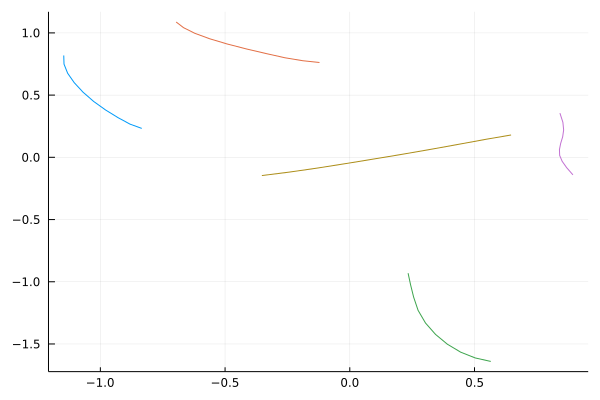

(layers[i], hidden[i]) = (2, 50)
(mean_cost, std_cost, tot_time) = 

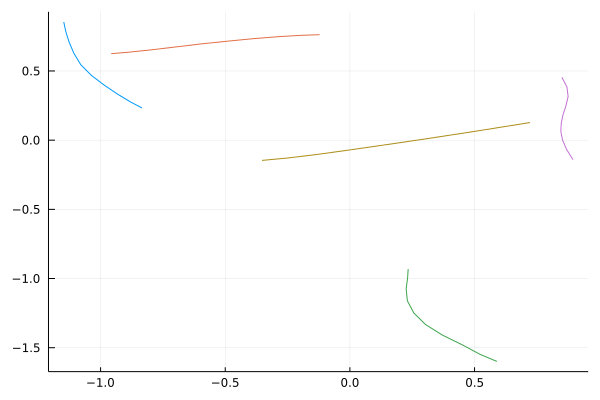

(2.3259124176111533e-8, 3.833052815262929e-8, 1.3529496030000001)
(layers[i], hidden[i]) = (2, 100)
(mean_cost, std_cost, tot_time) = 

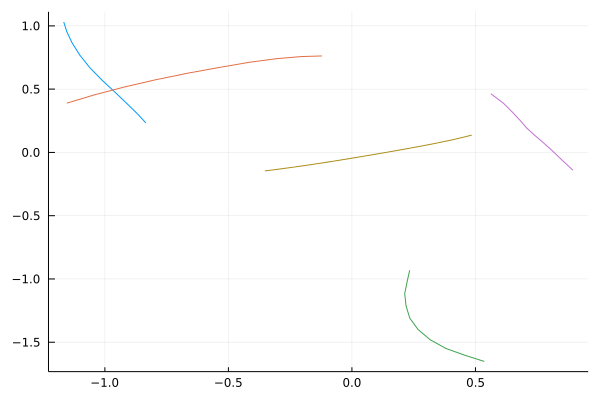

(3.318712979150096e-8, 4.5928420347875996e-8, 3.7610129010000004)
(layers[i], hidden[i]) = (2, 200)
(mean_cost, std_cost, tot_time) = 

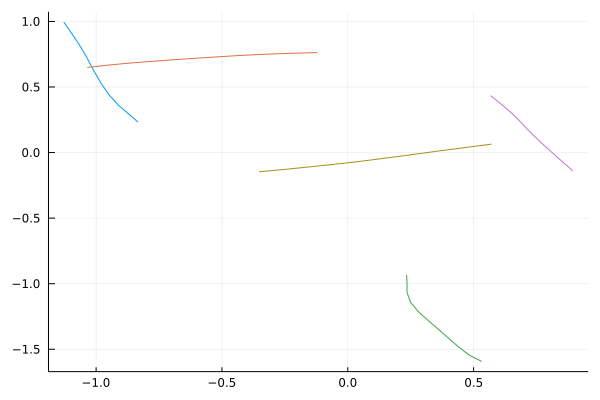

(5.205662060777938e-5, 0.0002593027871100076, 7.074311497)
(layers[i], hidden[i]) = (2, 300)
(mean_cost, std_cost, tot_time) = 

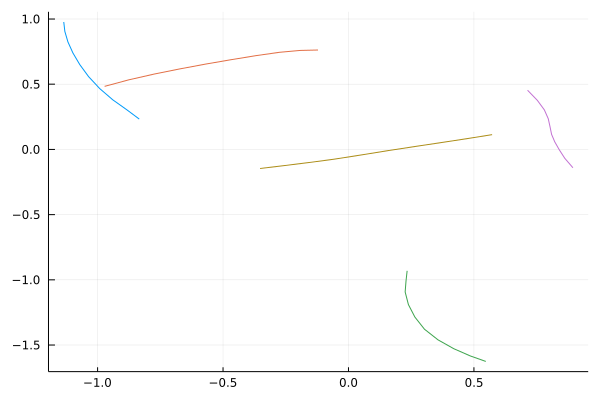

(1.302250730840504e-8, 5.335095677951446e-8, 11.591952914)
(layers[i], hidden[i]) = (2, 500)
(mean_cost, std_cost, tot_time) = 

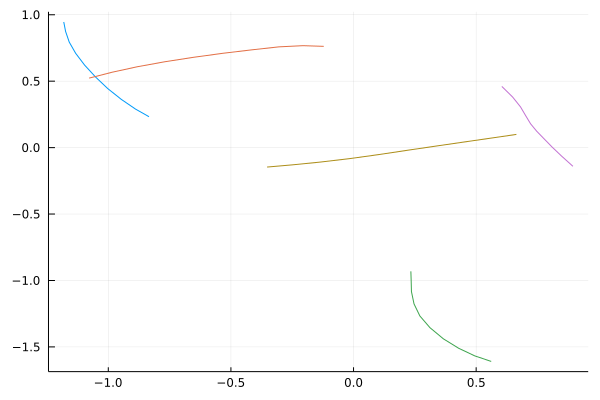

(0.00010976219634855316, 0.0003914977186420326, 29.111579908000003)
(layers[i], hidden[i]) = (2, 1000)
(mean_cost, std_cost, tot_time) = 

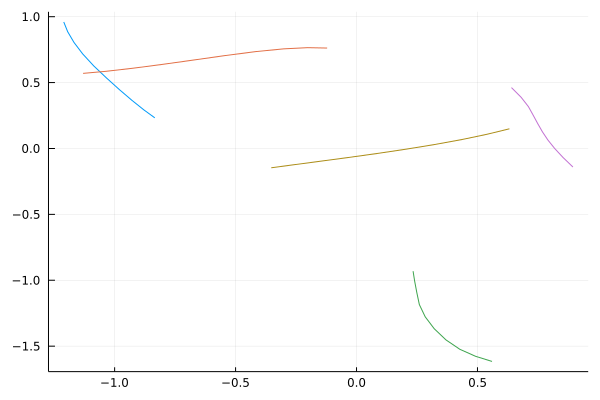

(8.363334167369965e-5, 0.0003702896743169808, 116.384980894)
(layers[i], hidden[i]) = (3, 50)
(mean_cost, std_cost, tot_time) = 

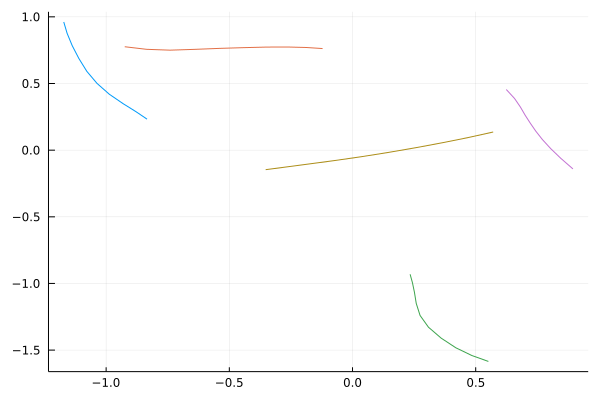

(1.1368507543962902e-8, 2.6680527913393933e-8, 3.653049865)
(layers[i], hidden[i]) = (3, 100)
(mean_cost, std_cost, tot_time) = 

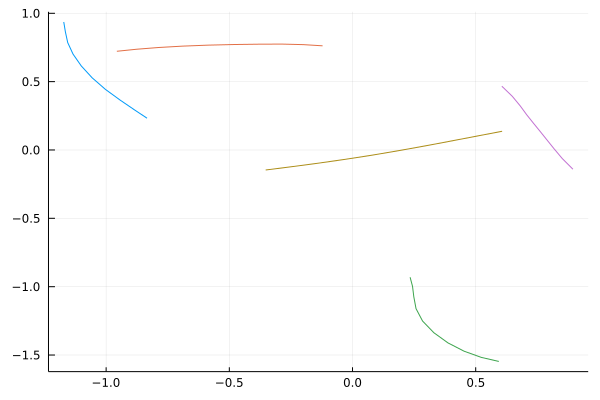

(6.8459860826097786e-9, 2.111327423713532e-8, 8.40611587)
(layers[i], hidden[i]) = (3, 200)
(mean_cost, std_cost, tot_time) = 

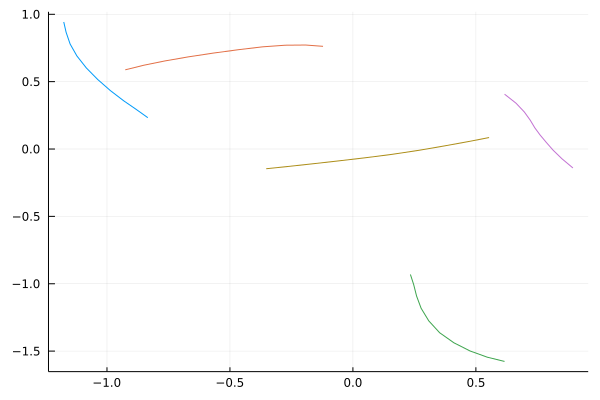

(3.941753813482135e-6, 2.6870948361601166e-5, 364.17095561200006)
(layers[i], hidden[i]) = (3, 300)
(mean_cost, std_cost, tot_time) = 

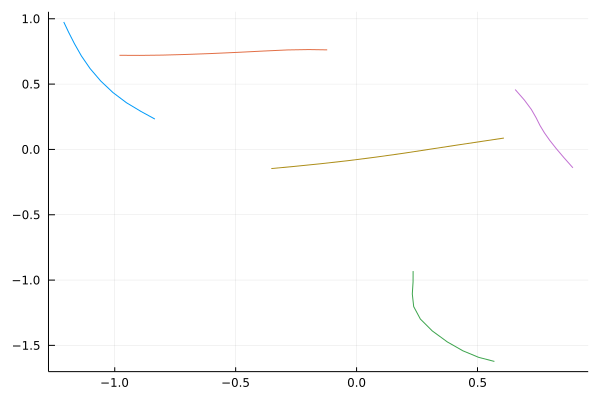

(6.916684419497485e-5, 0.0003300131129328046, 1660.0799355469999)
(layers[i], hidden[i]) = (4, 50)
(mean_cost, std_cost, tot_time) = 

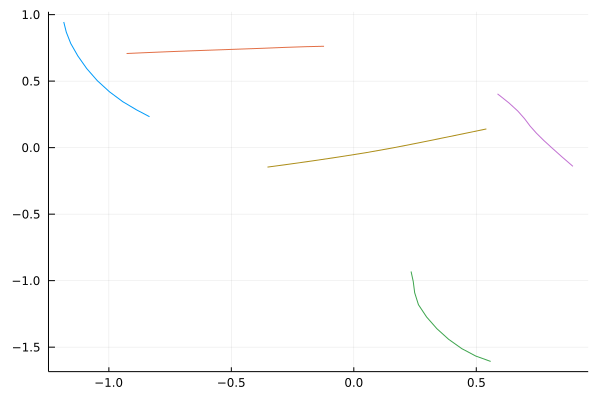

(8.676121534684222e-9, 1.745290936691574e-8, 13.005436417)
(layers[i], hidden[i]) = (4, 100)
(mean_cost, std_cost, tot_time) = 

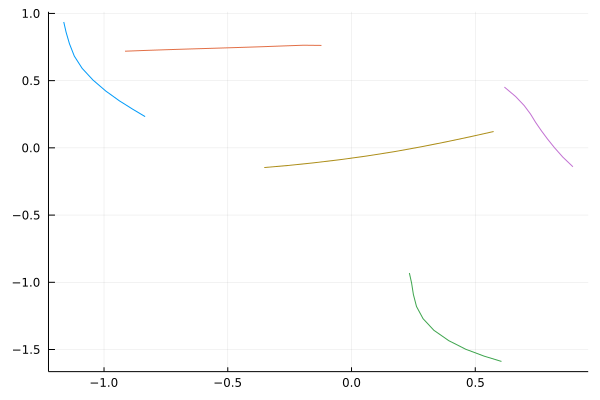

(1.1729546626759735e-8, 3.028332567549409e-8, 239.31886478599998)
(layers[i], hidden[i]) = (4, 200)


LoadError: [91mInterruptException:[39m

In [50]:
layers = [2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 5, 5]
hidden = [50, 100, 200, 300, 500, 1000, 50, 100, 200, 300, 50, 100, 200, 50, 100]
times = []
for i in 1:length(layers)
    @show  layers[i], hidden[i]
    net_path = "../nnet/unicycle-FC"*string(layers[i])*"-"*string(hidden[i])*"-rk4-extra/epoch_1000.nnet"
    mean_costs, std_costs, tot_times = nn_dynamics_tracking_state(net_path, 1, 10, 5)
    push!(times, tot_times[1])
end

In [52]:
times/50

12-element Array{Float64,1}:
  0.027058992060000002
  0.07522025802000001
  0.14148622994
  0.23183905828
  0.58223159816
  2.32769961788
  0.0730609973
  0.16812231740000003
  7.283419112240001
 33.20159871094
  0.26010872834
  4.7863772957199995

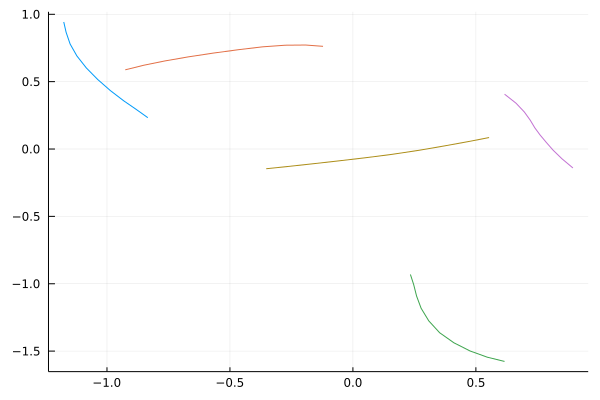

(layers[i], hidden[i]) = (3, 300)
(mean_cost, std_cost, tot_time) = (6.916684419497485e-5, 0.0003300131129328046, 1660.5172351150002)


In [10]:
layers = [3]
hidden = [300]
for i in 1:length(layers)
    @show  layers[i], hidden[i]
    net_path = "../nnet/unicycle-FC"*string(layers[i])*"-"*string(hidden[i])*"-rk4-extra/epoch_1000.nnet"
    mean_costs, std_costs, tot_times = nn_dynamics_tracking_state(net_path, 1, 10, 5)
end

In [ ]:
layers = [3]
hidden = [400]
for i in 1:length(layers)
    @show  layers[i], hidden[i]
    net_path = "../nnet/unicycle-FC"*string(layers[i])*"-"*string(hidden[i])*"-rk4-extra/epoch_1000.nnet"
    mean_costs, std_costs, tot_times = nn_dynamics_tracking_state(net_path, 1, 10, 5)
end

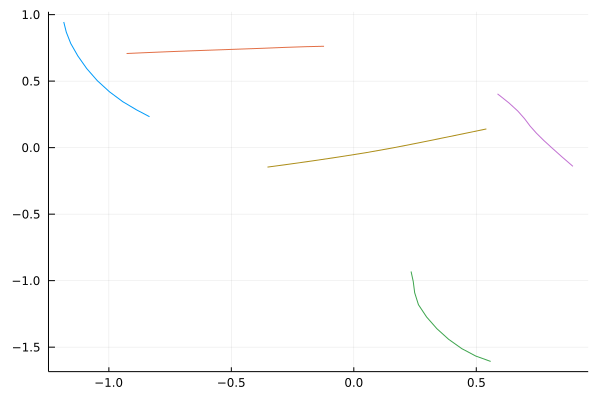

(layers[i], hidden[i]) = (4, 100)
(mean_cost, std_cost, tot_time) = (1.1729546626759735e-8, 3.028332567549409e-8, 239.97875070499998)


In [11]:
layers = [4]
hidden = [100]
for i in 1:length(layers)
    @show  layers[i], hidden[i]
    net_path = "../nnet/unicycle-FC"*string(layers[i])*"-"*string(hidden[i])*"-rk4-extra/epoch_1000.nnet"
    mean_costs, std_costs, tot_times = nn_dynamics_tracking_state(net_path, 1, 10, 5)
end

In [7]:
layers = [4]
hidden = [200]
for i in 1:length(layers)
    @show  layers[i], hidden[i]
    net_path = "../nnet/unicycle-FC"*string(layers[i])*"-"*string(hidden[i])*"-rk4-extra/epoch_1000.nnet"
    mean_costs, std_costs, tot_times = nn_dynamics_tracking_state(net_path, 1, 10, 5)
end

(layers[i], hidden[i]) = (4, 200)


LoadError: [91mSystemError: opening file "../nnet/unicycle-FC4-200-rk4-extra/epoch_1000.nnet": No such file or directory[39m

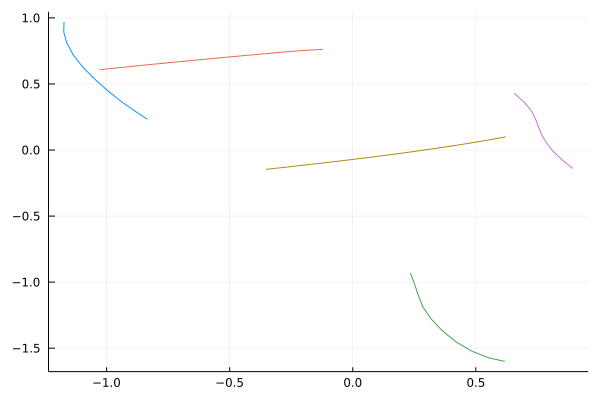

(layers[i], hidden[i]) = (5, 50)
(mean_cost, std_cost, tot_time) = (9.286669568203676e-9, 1.54267027992548e-8, 111.18268018200001)


In [53]:
layers = [5]
hidden = [50]
for i in 1:length(layers)
    @show  layers[i], hidden[i]
    net_path = "../nnet/unicycle-FC"*string(layers[i])*"-"*string(hidden[i])*"-rk4-extra/epoch_1000.nnet"
    mean_costs, std_costs, tot_times = nn_dynamics_tracking_state(net_path, 1, 10, 5)
end

In [54]:
111.18268018200001/50

2.2236536036400003

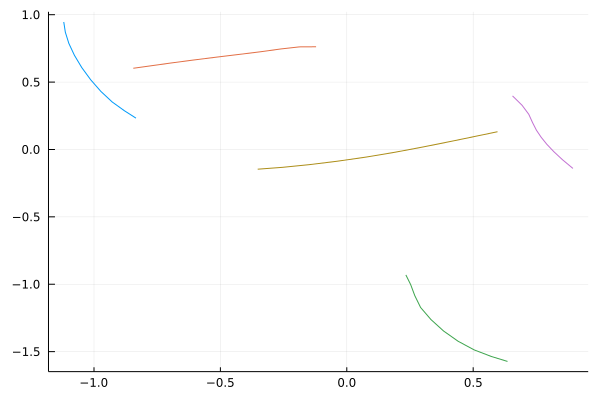

(layers[i], hidden[i]) = (5, 100)
(mean_cost, std_cost, tot_time) = (9.252995607778036e-9, 1.5094927402049486e-8, 1440.967892535)


In [12]:
layers = [5]
hidden = [100]
for i in 1:length(layers)
    @show  layers[i], hidden[i]
    net_path = "../nnet/unicycle-FC"*string(layers[i])*"-"*string(hidden[i])*"-rk4-extra/epoch_1000.nnet"
    mean_costs, std_costs, tot_times = nn_dynamics_tracking_state(net_path, 1, 10, 5)
end

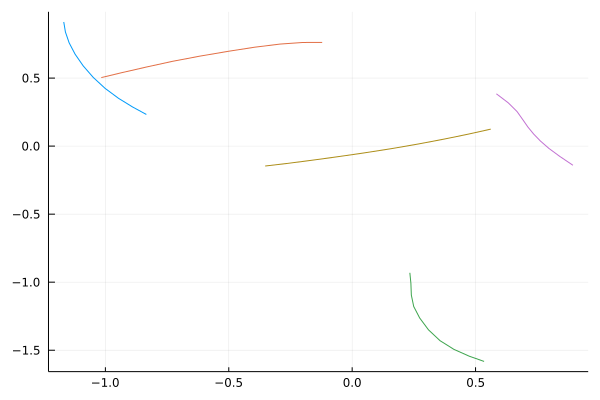

(layers[i], hidden[i]) = (6, 100)


In [ ]:
layers = [6]
hidden = [100]
for i in 1:length(layers)
    @show  layers[i], hidden[i]
    net_path = "../nnet/unicycle-FC"*string(layers[i])*"-"*string(hidden[i])*"-rk4-extra/epoch_1000.nnet"
    mean_costs, std_costs, tot_times = nn_dynamics_tracking_state(net_path, 1, 10, 5)
end

In [2]:
[3.64, 8.38, 365.735621851, 1660.5172351150002, 12.35, 239.97875070499998, 1440.967892535] / 50

7-element Array{Float64,1}:
  0.0728
  0.16760000000000003
  7.314712437020001
 33.210344702300006
  0.247
  4.799575014099999
 28.819357850699998

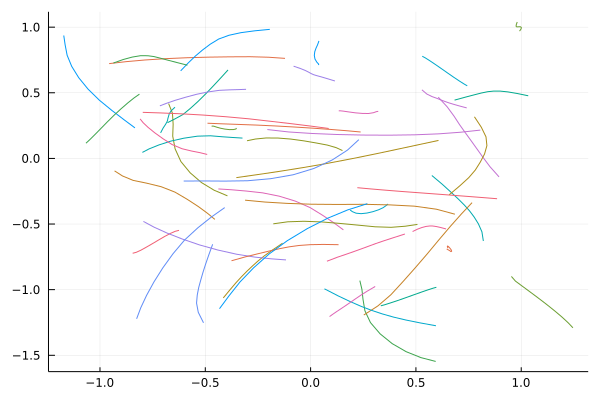

(layers[i], hidden[i]) = (3, 200)
(mean_cost, std_cost, tot_time) = 

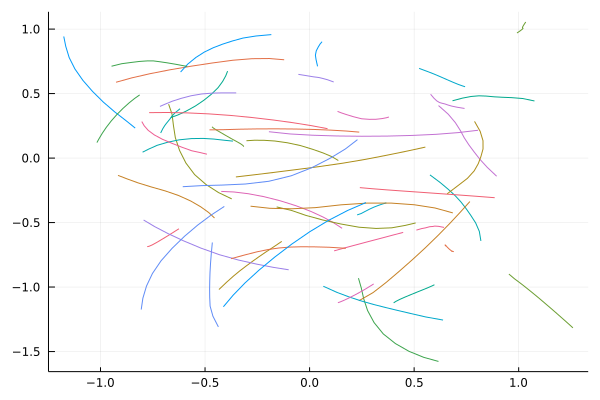

(1.0120751025913949e-8, 2.1806430671543564e-8, 3246.021960962)
(layers[i], hidden[i]) = (3, 300)


In [ ]:
layers = [3,3,4,5]
hidden = [200, 300, 100, 100]
for i in 1:4
    @show  layers[i], hidden[i]
    net_path = "../nnet/unicycle-FC"*string(layers[i])*"-"*string(hidden[i])*"-rk4-extra/epoch_1000.nnet"
    mean_costs, std_costs, tot_times = nn_dynamics_tracking_state(net_path, 1, 10, 50)
end

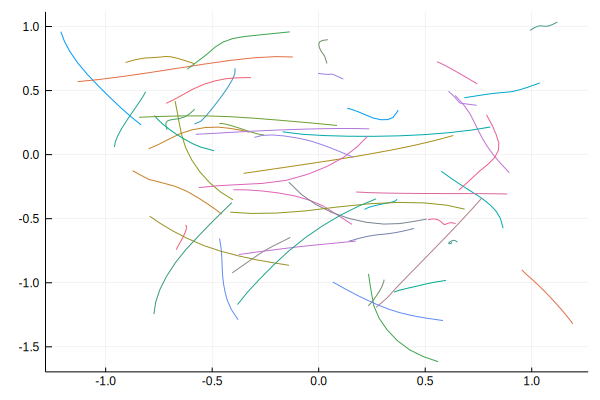

(mean_cost, std_cost, tot_time) = (1.0895788559974612e-8, 3.083755027102314e-8, 50.390301906999994)
(mean_cost, std_cost, tot_time) = (0.12969996782949633, 0.08054006985445446, 2.056006229)
(mean_cost, std_cost, tot_time) = (0.04136016129611548, 0.02650465274419478, 18.877258890000004)
(mean_cost, std_cost, tot_time) = (0.012447531370764039, 0.00787737761914061, 192.70776031099996)

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

(mean_cost, std_cost, tot_time) = (1.8716195571270666, 0.6261442962556351, 18.422422558)
(mean_cost, std_cost, tot_time) = (1.871619557220702, 0.6261442962866007, 14.105904870000002)


(Any[1.0895788559974612e-8, 0.12969996782949633, 0.04136016129611548, 0.012447531370764039, 1.8716195571270666, 1.871619557220702], Any[3.083755027102314e-8, 0.08054006985445446, 0.02650465274419478, 0.00787737761914061, 0.6261442962556351, 0.6261442962866007], Any[50.390301906999994, 2.056006229, 18.877258890000004, 192.70776031099996, 18.422422558, 14.105904870000002])

In [5]:
net_path = "../nnet/unicycle-FC3-50-rk4-so/epoch_1000.nnet"
mean_costs, std_costs, tot_times = nn_dynamics_tracking_state(net_path, 1, 10, 50)

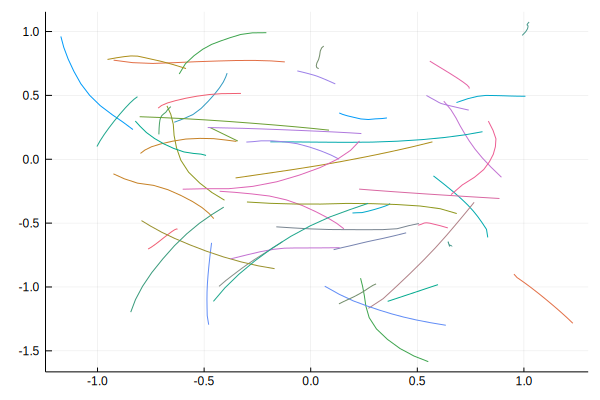

(mean_cost, std_cost, tot_time) = (6.489099810321613e-9, 1.977044452870109e-8, 83.77855461800002)
(mean_cost, std_cost, tot_time) = (0.1284852426391819, 0.08074564136185328, 10.005950964000002)
(mean_cost, std_cost, tot_time) = (0.04145651698209728, 0.02682154645368886, 100.19791966099999)
(mean_cost, std_cost, tot_time) = (0.012368349096048519, 0.007841982353836362, 1006.2647876510001)
(mean_cost, std_cost, tot_time) = (1.8527095218638485, 0.6192430470781894, 3.9519386940000003)
(mean_cost, std_cost, tot_time) = (1.8527095220875787, 0.6192430471562185, 16.299819683000003)


(Any[6.489099810321613e-9, 0.1284852426391819, 0.04145651698209728, 0.012368349096048519, 1.8527095218638485, 1.8527095220875787], Any[1.977044452870109e-8, 0.08074564136185328, 0.02682154645368886, 0.007841982353836362, 0.6192430470781894, 0.6192430471562185], Any[83.77855461800002, 10.005950964000002, 100.19791966099999, 1006.2647876510001, 3.9519386940000003, 16.299819683000003])

In [10]:
net_path = "../nnet/unicycle-FC3-100-rk4/epoch_1000.nnet"
mean_costs, std_costs, tot_times = nn_dynamics_tracking_state(net_path, 1, 10, 50)

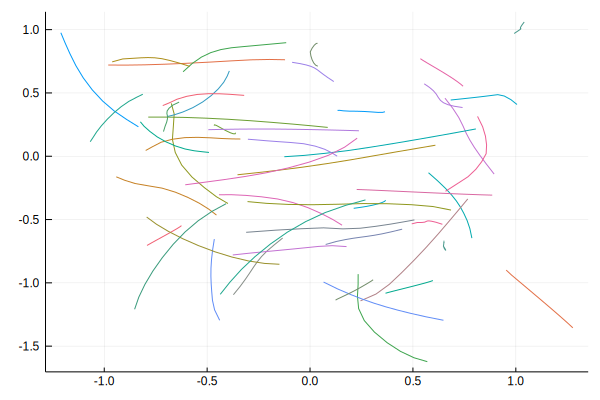

(mean_cost, std_cost, tot_time) = (7.578618859598388e-9, 1.5383480439942885e-8, 123.97852156799996)
(mean_cost, std_cost, tot_time) = (0.12857496457396428, 0.08016104194199944, 2.7265474340000004)
(mean_cost, std_cost, tot_time) = (0.04170528429248156, 0.02651888167336649, 27.34568216700001)
(mean_cost, std_cost, tot_time) = (0.012454351167091869, 0.007900240123822323, 272.4250334050001)
(mean_cost, std_cost, tot_time) = (1.8657904100085392, 0.6237601427277782, 3.5084003669999997)
(mean_cost, std_cost, tot_time) = (1.8657904101049583, 0.6237601427620205, 14.396685873000003)


(Any[7.578618859598388e-9, 0.12857496457396428, 0.04170528429248156, 0.012454351167091869, 1.8657904100085392, 1.8657904101049583], Any[1.5383480439942885e-8, 0.08016104194199944, 0.02651888167336649, 0.007900240123822323, 0.6237601427277782, 0.6237601427620205], Any[123.97852156799996, 2.7265474340000004, 27.34568216700001, 272.4250334050001, 3.5084003669999997, 14.396685873000003])

In [6]:
net_path = "../nnet/unicycle-FC4-50-rk4-so/epoch_1000.nnet"
mean_costs, std_costs, tot_times = nn_dynamics_tracking_state(net_path, 1, 10, 50)

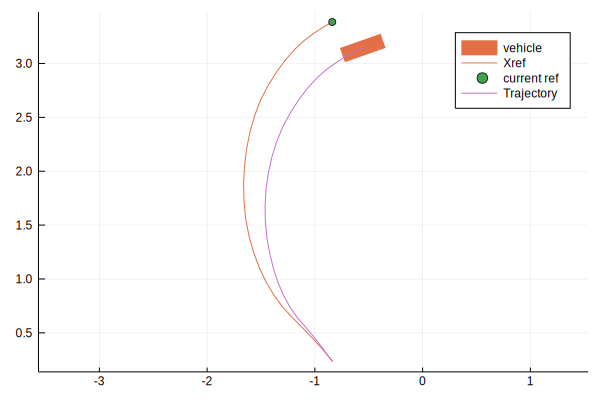

mean(costs(tp, Xtrack)) = 2.1937339953435013


2.1937339953435013

In [11]:
net_path = "../nnet/unicycle-FC3-100-rk4/epoch_1000.nnet"
net = read_nnet(net_path);
obj_cost = [1,1,10,10];
Random.seed!(127);

tf = 3
T = 30
Xrefs, Urefs = generate_random_traj(net, 1, tf, T);
Xref=Xrefs[1]
tp = TP(net, obj_cost, tf, Xref);

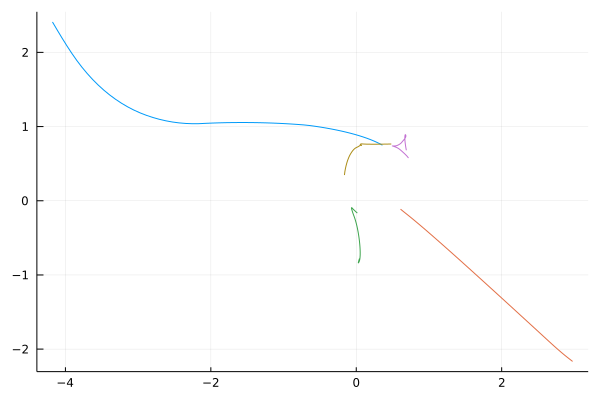

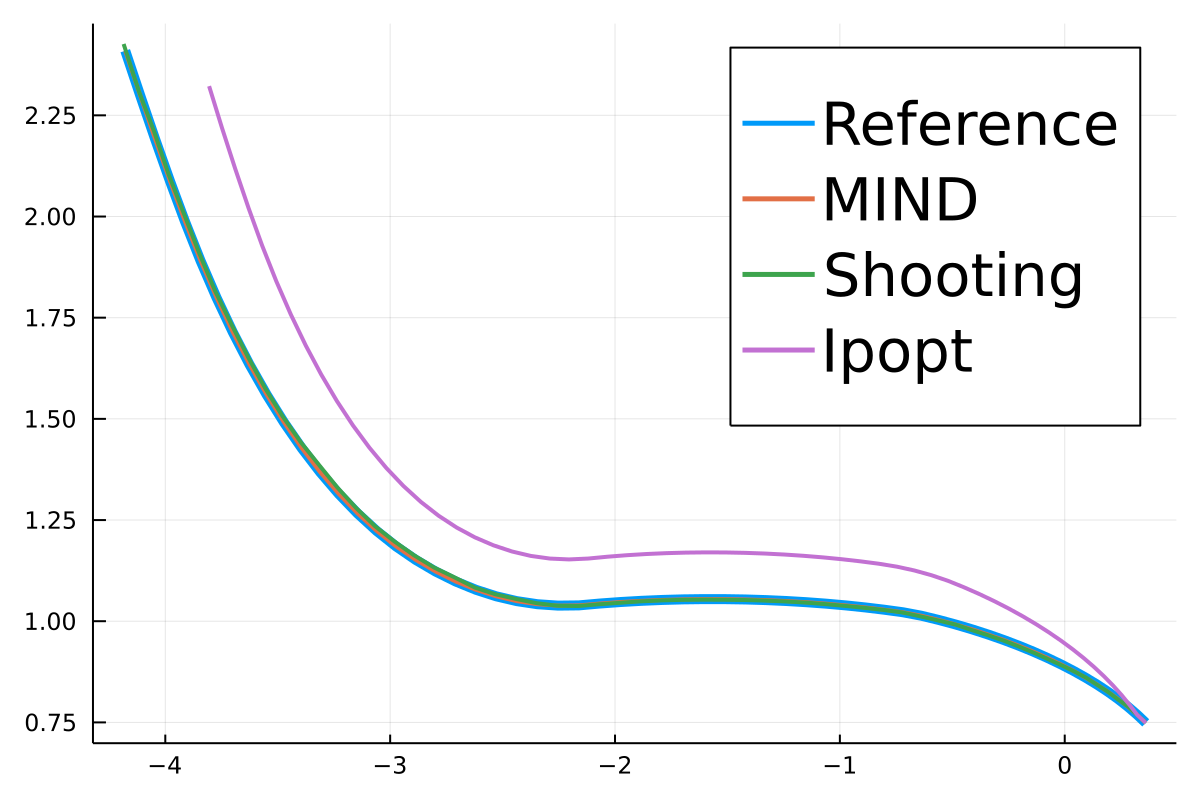

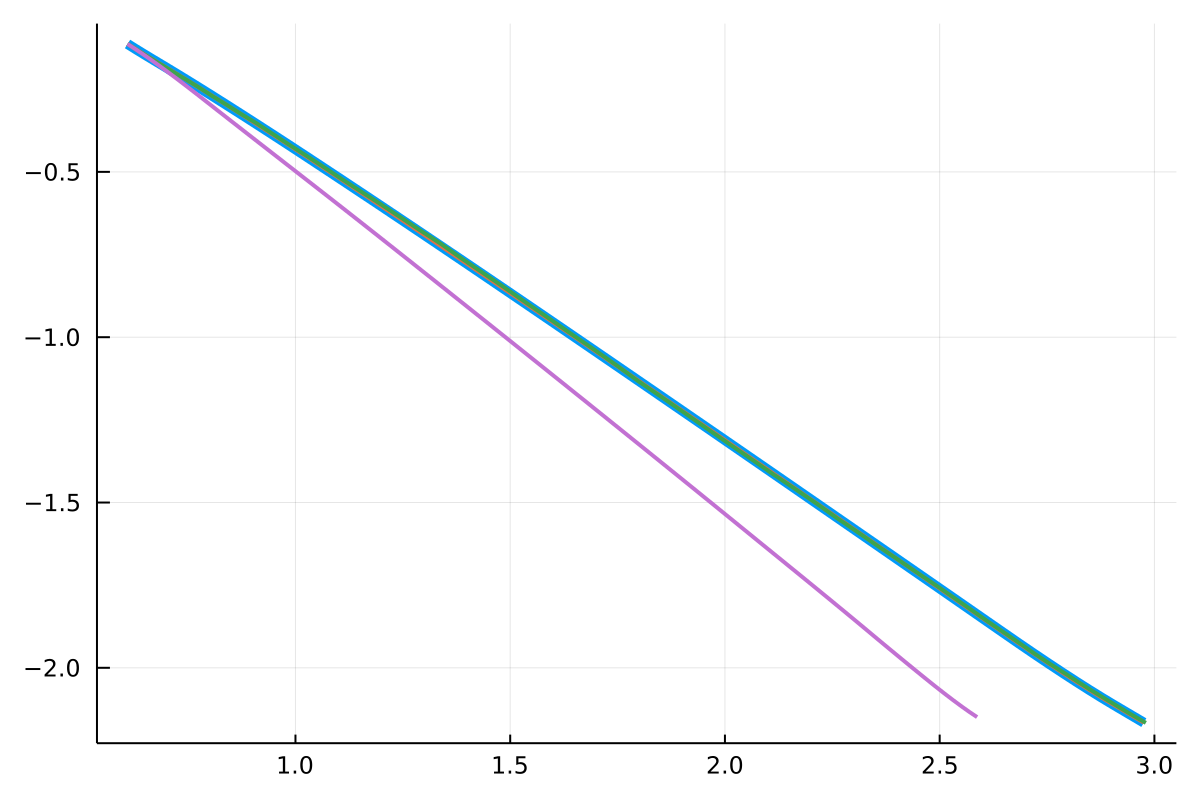

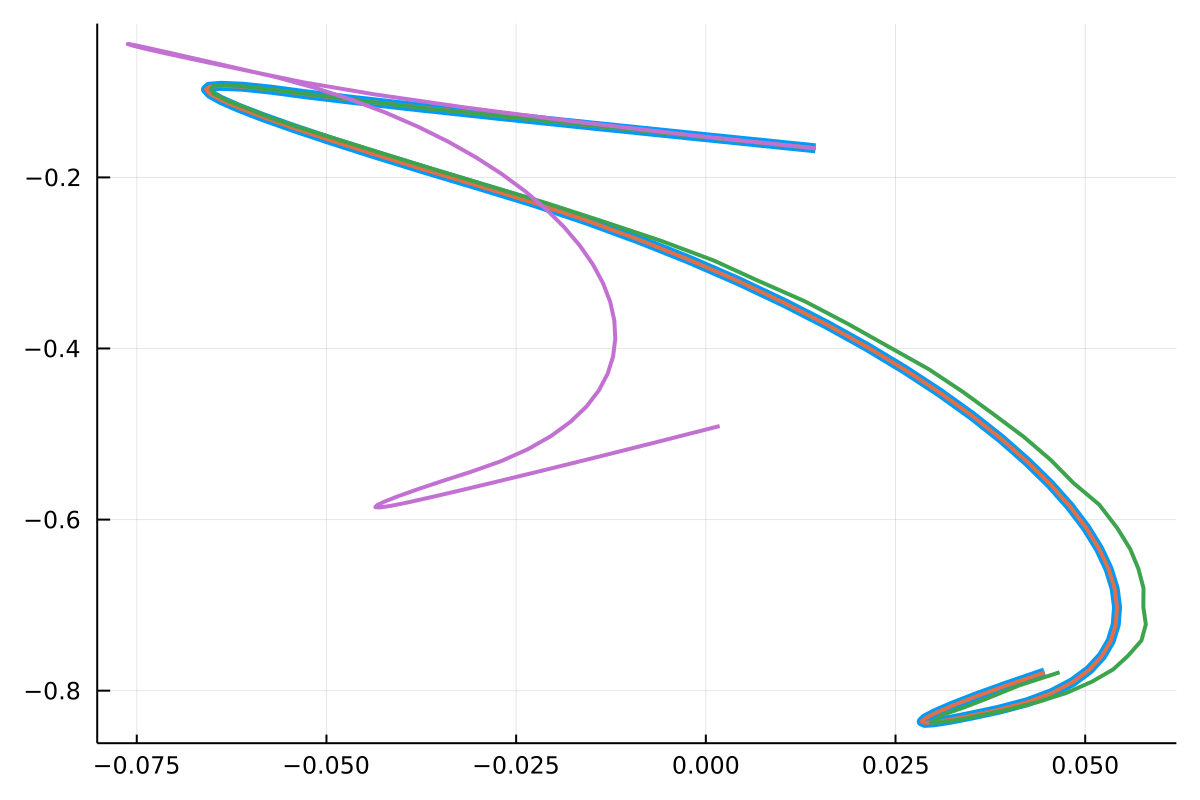

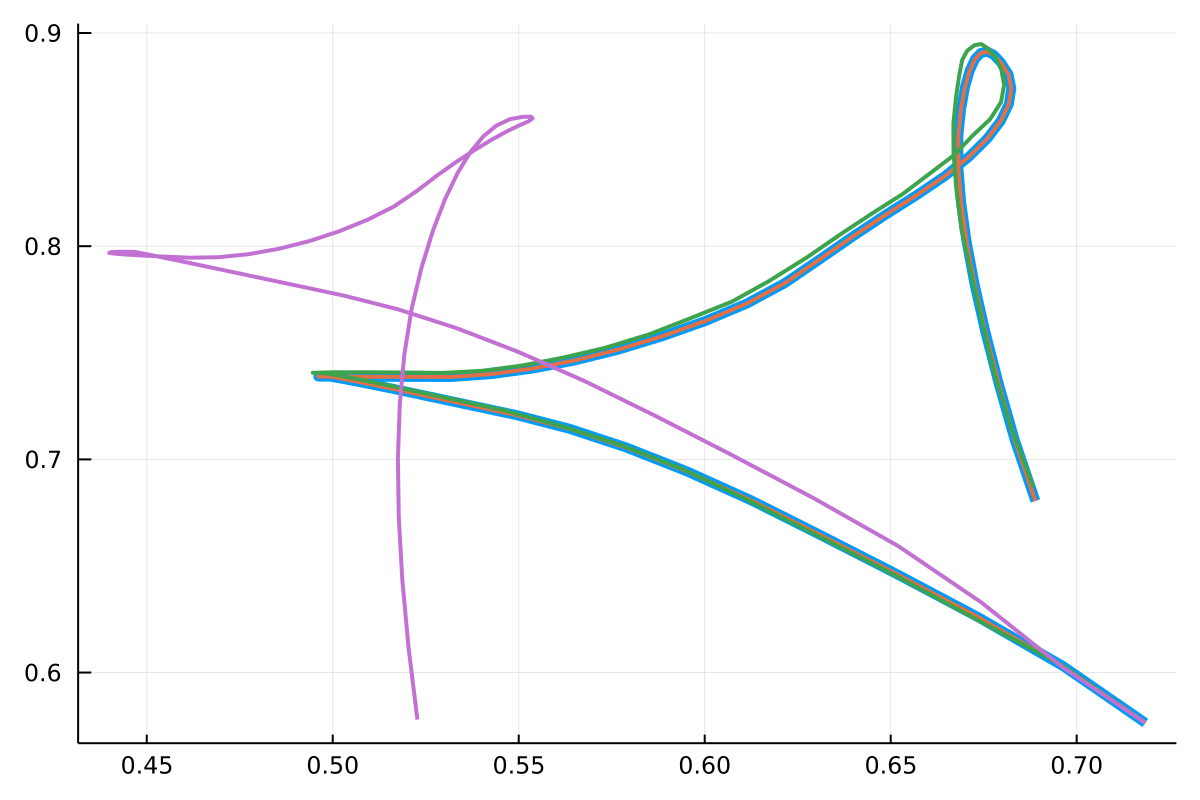

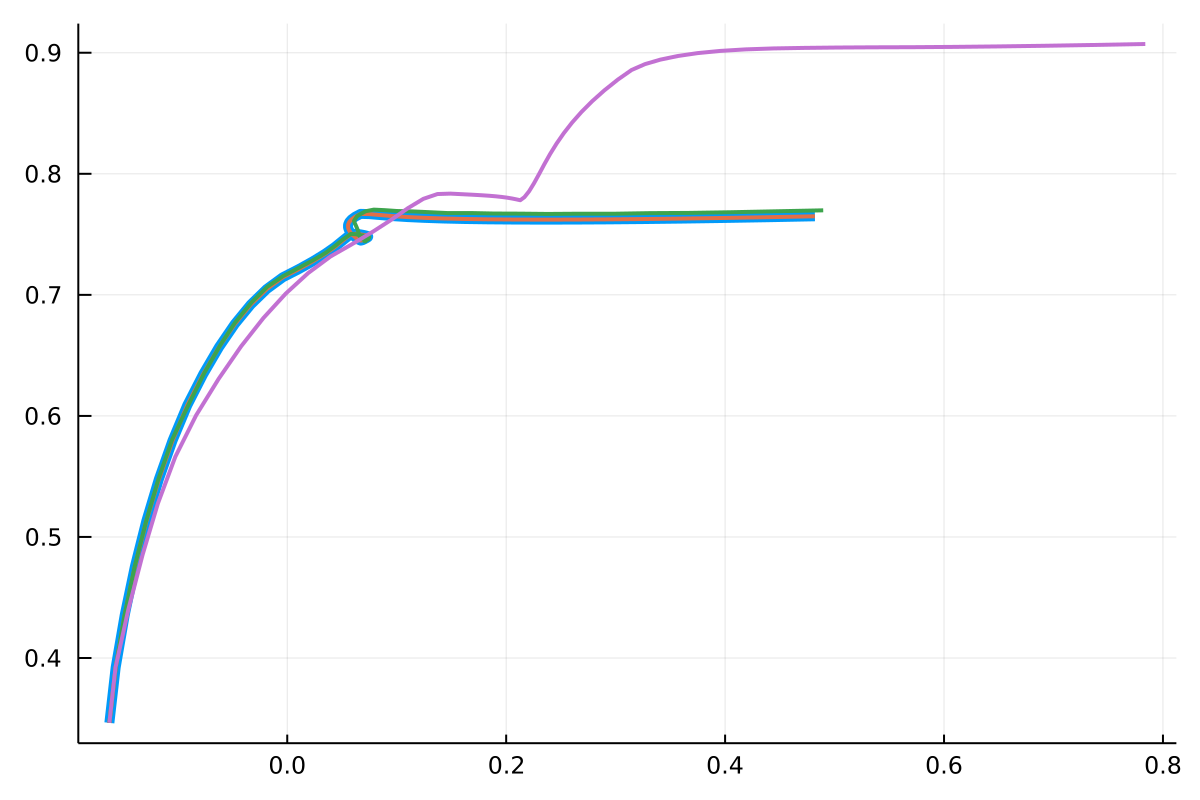


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



In [5]:
function draw_tracking_compare(net_path, tf, T, num;)
    net = read_nnet(net_path);
    obj_cost = [1,1,10,10];
    Random.seed!(4);

    Xrefs, Urefs = generate_random_traj(net, num, tf, T);
    p = plot()
    for k = 1:num
        xs = [Xrefs[k][i][1] for i in 1:length(Xrefs[k])]
        ys = [Xrefs[k][i][2] for i in 1:length(Xrefs[k])]
        plot!(xs, ys, legend = false)
    end
    display(p)
    
    err_bound = [1, 1, 0.1, 0.1]*100
    nv_ctrl = NvController(err_bound, warm_start=true, bin_precision=2)
    nl_ctrl_original = NlController(err_bound, warm_start=false)
    err_bound = [1, 1, 0.1, 0.1]*1
    nl_ctrl_bounded = NlController(err_bound, warm_start=true)
    shoot_100 = ShootingController(100);
#     ctrls = [nv_ctrl, shoot_100, nl_ctrl_original]
#     labels = ["MIP", "Shooting", "Ipopt original"]
    ctrls = [nv_ctrl, shoot_100, nl_ctrl_bounded]
    labels = ["MIND", "Shooting", "Ipopt"]
    
    for k = 1:num
        p = k == 1 ? plot(dpi=200) : plot(legend=:none, dpi=200)
#         p = plot(dpi=200)
        xs = [Xrefs[k][i][1] for i in 1:length(Xrefs[k])]
        ys = [Xrefs[k][i][2] for i in 1:length(Xrefs[k])]
        plot!(xs, ys, linewidth=5, label="Reference", legendfontsize=20)
        Xtracks = []
        for (i,ctrl) in enumerate(ctrls)
            tp = TP(net, obj_cost, tf, Xrefs[k]);
            Xtrack, Utrack, time = tracking(tp, ctrl, verbose=false, only_one_step=false)
            xs = [Xtrack[j][1] for j in 1:length(Xtrack)]
            ys = [Xtrack[j][2] for j in 1:length(Xtrack)]
            plot!(xs, ys, linewidth=2, label=labels[i])
        end
        display(p)
        savefig("../results/tracking_bounded_"*string(k)*".png")
    end
end
net_path = "../nnet/unicycle-FC3-100-rk4/epoch_1000.nnet"
draw_tracking_compare(net_path, 3, 60, 5)

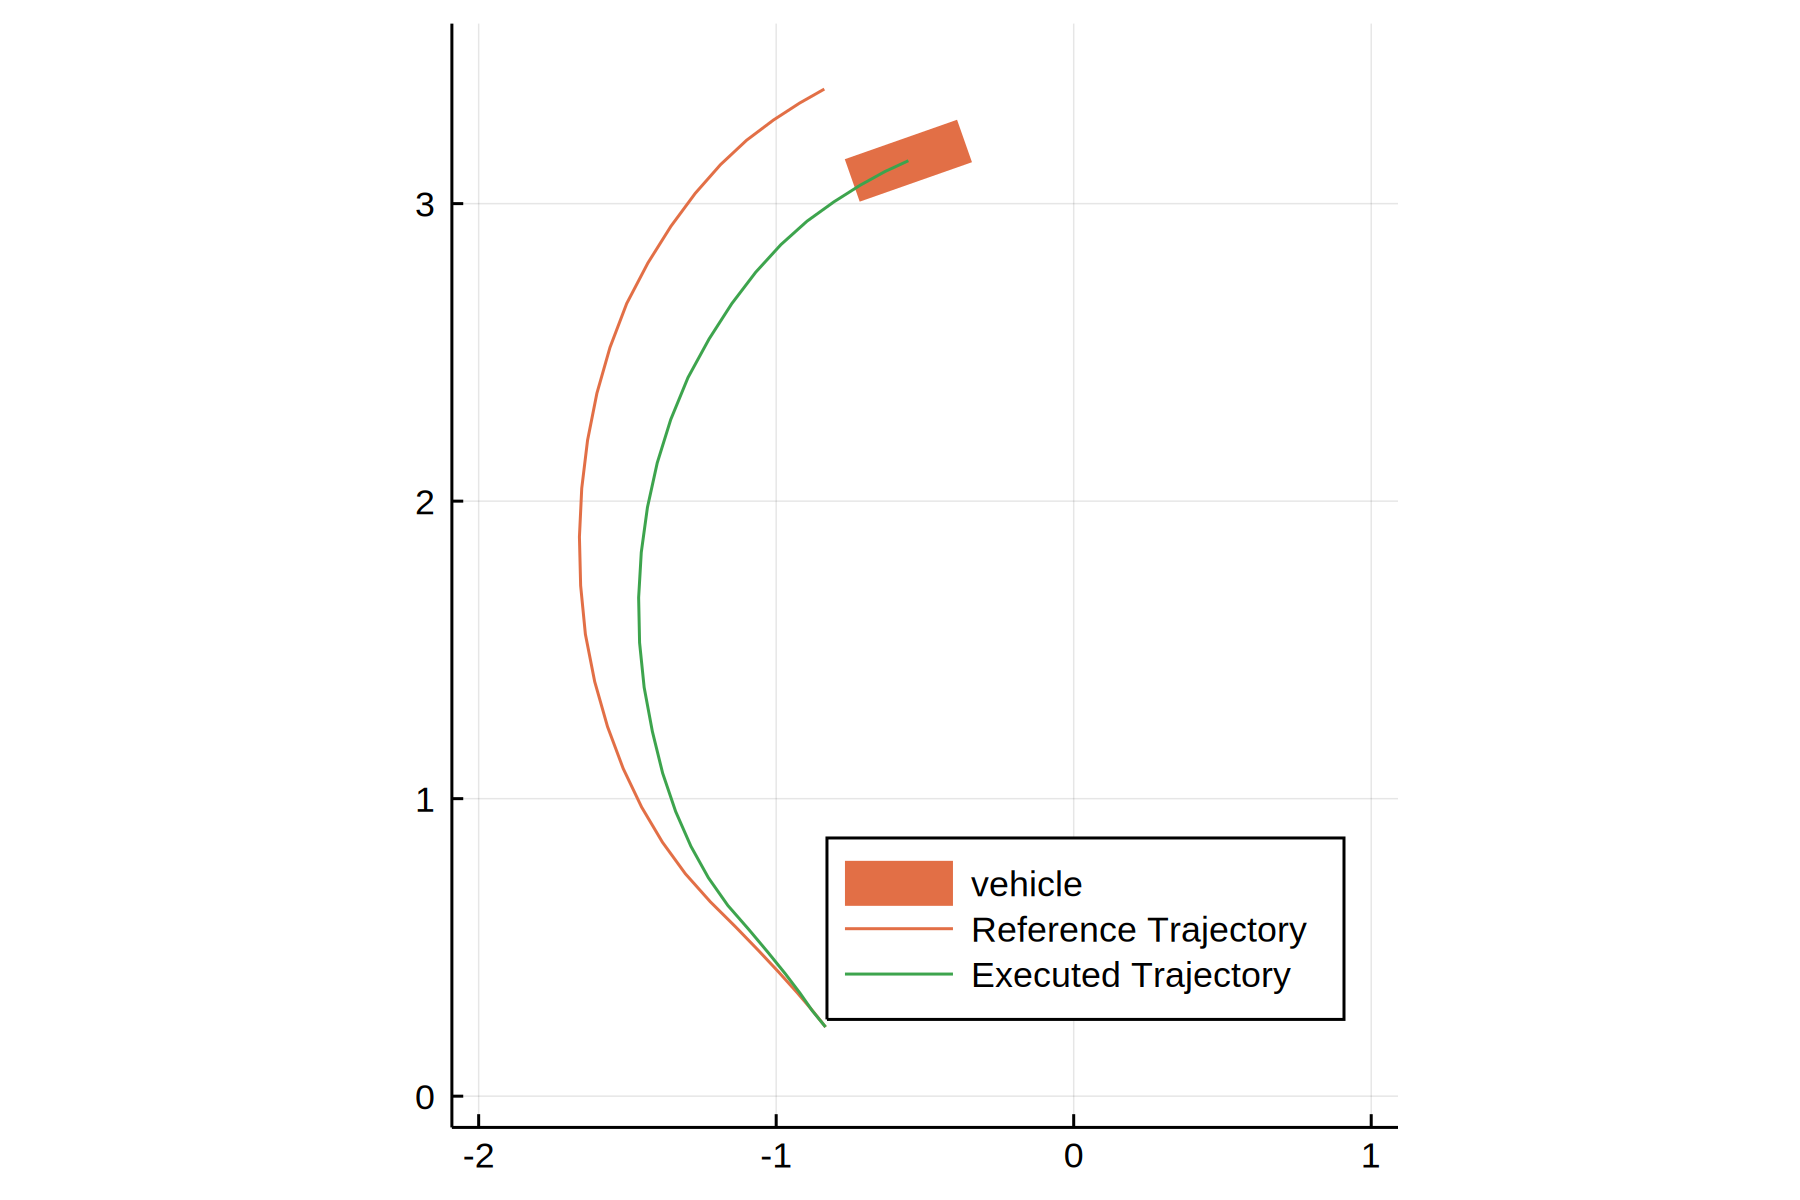

mean(costs(tp, Xtrack)) = 2.1937339953435013


2.1937339953435013

In [62]:
err_bound = [1, 1, 0.1, 0.1]
nl_iter_ctrl = NlController(err_bound, iter=5)
ctrl = nl_iter_ctrl
Xtrack, Utrack, time = tracking(tp, ctrl, verbose=false, only_one_step=false)
visualize(Xtrack, Xref=Xref, xlims=[-2,1], ylims=[0,3.5], save_frame=(29,"../results/track_nl.png"))
@show mean(costs(tp, Xtrack))

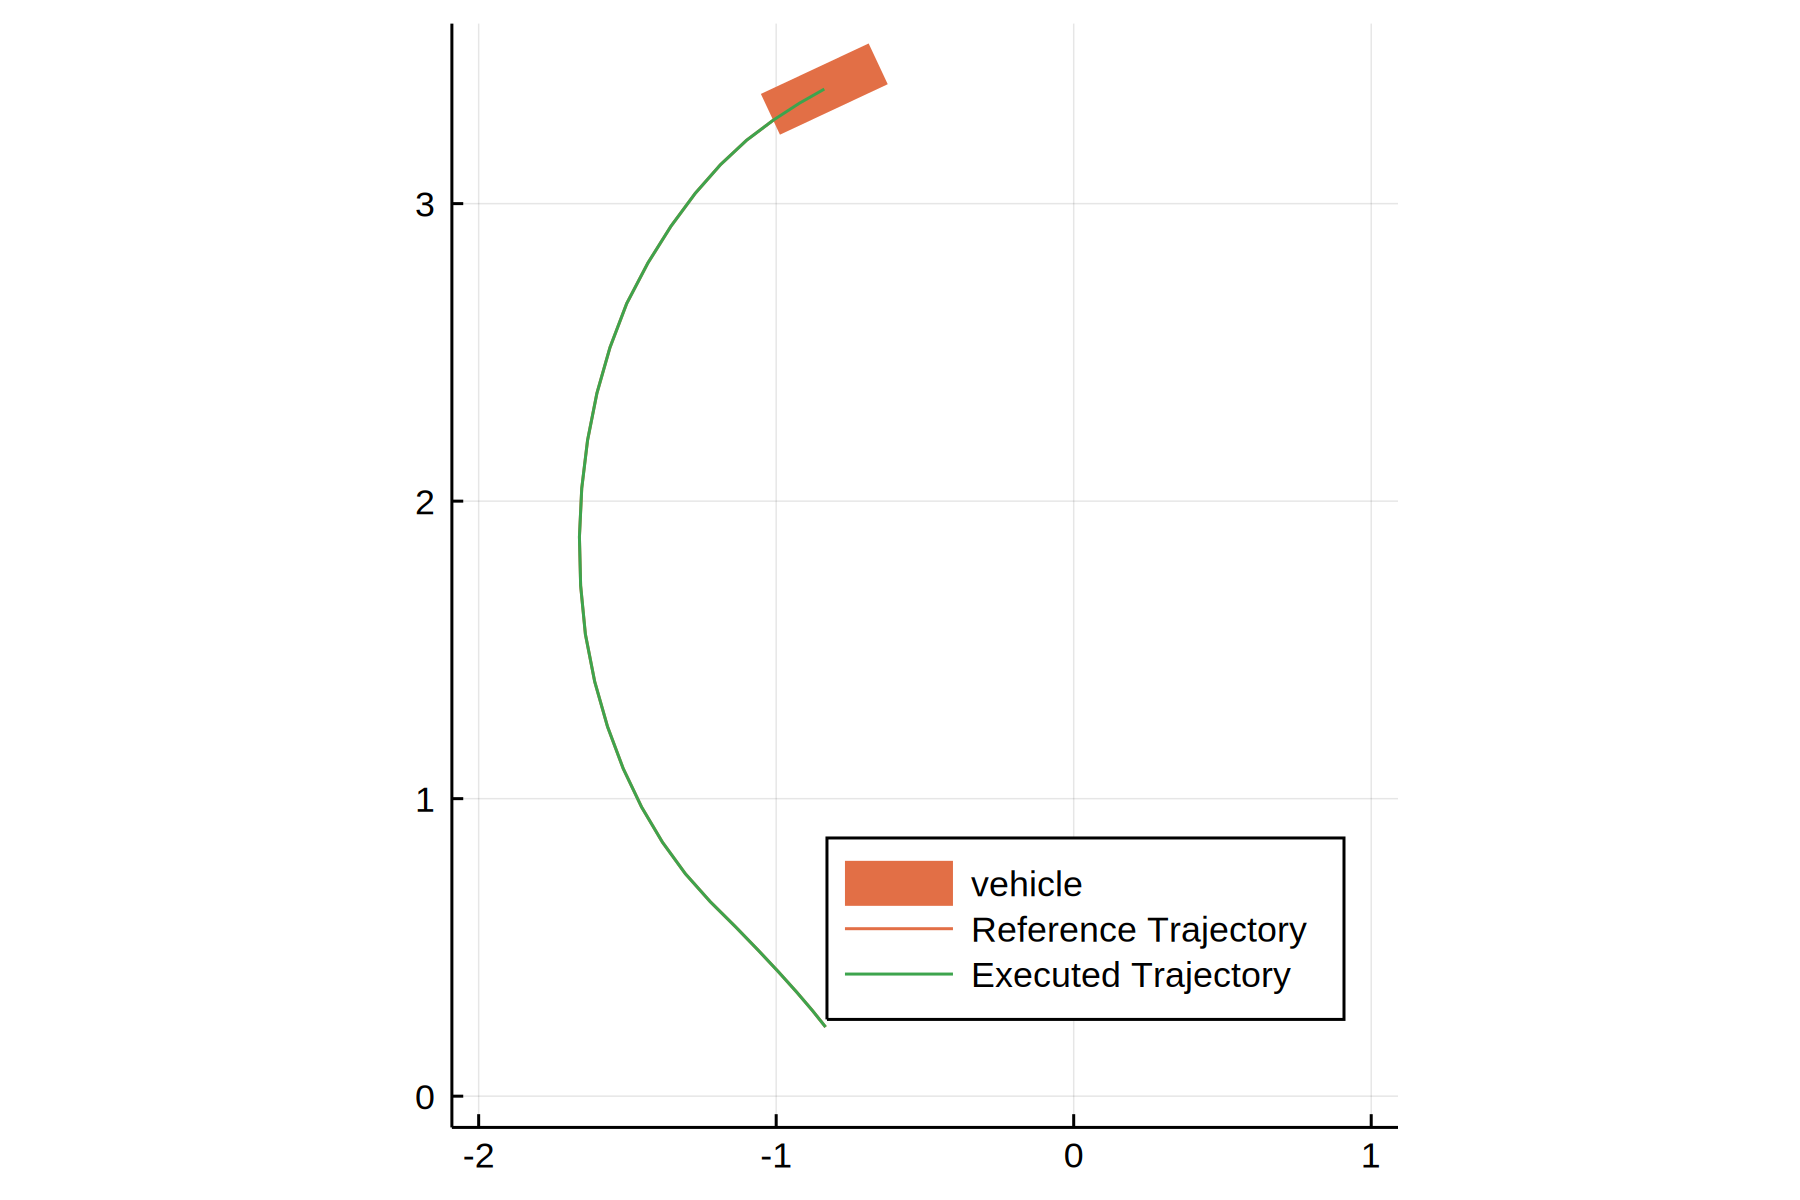

mean(costs(tp, Xtrack)) = 4.5020973097701735e-9


4.5020973097701735e-9

In [67]:
tp = TP(net, obj_cost, tf, Xref);
err_bound = [1, 1, 0.1, 0.1]
err_bound = [1, 1, 0.1, 0.1]
nv_ctrl = NvController(err_bound, warm_start=true, bin_precision=2)
ctrl = nv_ctrl
Xtrack, Utrack, time = tracking(tp, ctrl, verbose=false, only_one_step=false)
visualize(Xtrack, Xref=Xref, xlims=[-2,1], ylims=[0,3.5], save_frame=(29,"../results/track_nv.png"))
@show mean(costs(tp, Xtrack))

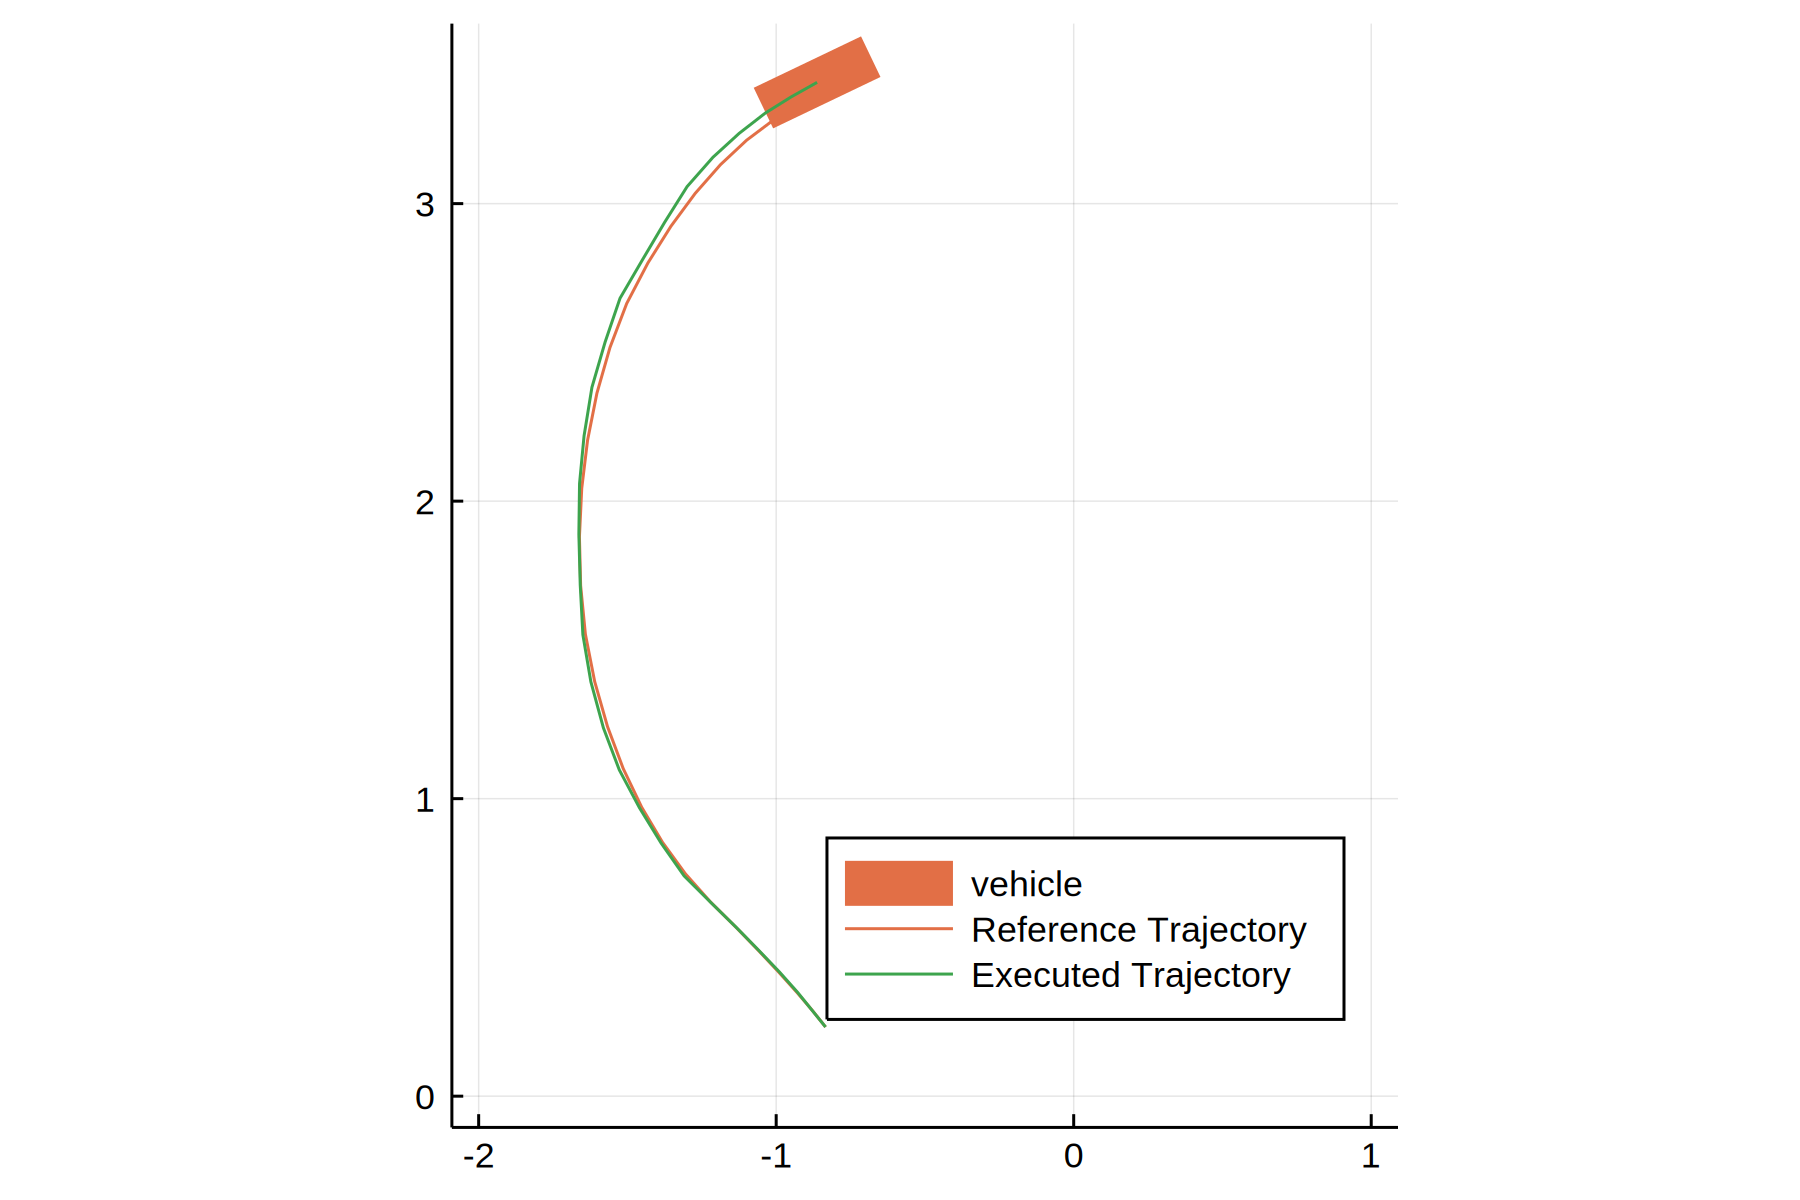

mean(costs(tp, Xtrack)) = 0.5108353752102361


0.5108353752102361

In [68]:
tp = TP(net, obj_cost, tf, Xref);
shoot_ctrl = ShootingController(100)
ctrl = shoot_ctrl
Xtrack, Utrack, time = tracking(tp, ctrl, verbose=false, only_one_step=false)
visualize(Xtrack, Xref=Xref, xlims=[-2,1], ylims=[0,3.5], save_frame=(29,"../results/track_shoot.png"))
@show mean(costs(tp, Xtrack))

In [7]:
function draw_tracking_compare(net_path, tf, T, num;)
    net = read_nnet(net_path);
    obj_cost = [1,1,10,10];
    Random.seed!(4);

    Xrefs, Urefs = generate_random_traj(net, num, tf, T);
    p = plot()
    for k = 1:num
        xs = [Xrefs[k][i][1] for i in 1:length(Xrefs[k])]
        ys = [Xrefs[k][i][2] for i in 1:length(Xrefs[k])]
        plot!(xs, ys, legend = false)
    end
    display(p)
    
    err_bound = [1, 1, 1, 1]*100
    nv_ctrl = NvController(err_bound, warm_start=false, bin_precision=2)
    nl_ctrl = NlController(err_bound, warm_start=false)
    shoot_100 = ShootingController(100);
    ctrls = [nv_ctrl, shoot_100, nl_ctrl]
    labels = ["MIND", "Shooting", "Ipopt_original"]
    
    for k = 1:num
        if k != 1 && k != 3 && k != 4
            continue
        end
        p = k == 1 ? plot(dpi=200) : plot(legend=:none, dpi=200)
#         p = plot(dpi=200)
        xs = [Xrefs[k][i][1] for i in 1:length(Xrefs[k])]
        ys = [Xrefs[k][i][2] for i in 1:length(Xrefs[k])]
        plot!(xs, ys, linewidth=5, label="Reference", legendfontsize=20)
        Xtracks = []
        Utracks = []
        for (i,ctrl) in enumerate(ctrls)
            tp = TP(net, obj_cost, tf, Xrefs[k]);
            Xtrack, Utrack, time = tracking(tp, ctrl, verbose=false, only_one_step=false)
            push!(Utracks, Utrack)
            xs = [Xtrack[j][1] for j in 1:length(Xtrack)]
            ys = [Xtrack[j][2] for j in 1:length(Xtrack)]
            plot!(xs, ys, linewidth=2, label=labels[i])
        end
#         display(p)
#         savefig("../results/tracking_traj_"*string(k)*".png")
        
        p1 = k == 1 ? plot(dpi=200) : plot(legend=:none, dpi=200)
        p2 = k == 1 ? plot(dpi=200) : plot(legend=:none, dpi=200)
        for i = 1:length(Utracks)
            uv = [u[1] for u in Utracks[i]]
            ua = [u[2] for u in Utracks[i]]
            plot!(p1, uv, label=labels[i], linewidth=2, legendfontsize=20)
            plot!(p2, ua, label=labels[i], linewidth=2, legendfontsize=20)
        end
        xlabel!(p1, "time step")
        xlabel!(p2, "time step")
        ylabel!(p1, "control 1")
        ylabel!(p2, "control 2")
        l = @layout [a; b]
        plot(p1, p2, layout = l, dpi=200)
        savefig("../results/tracking_original_control_"*string(k)*".png")
    end
end

draw_tracking_compare (generic function with 1 method)

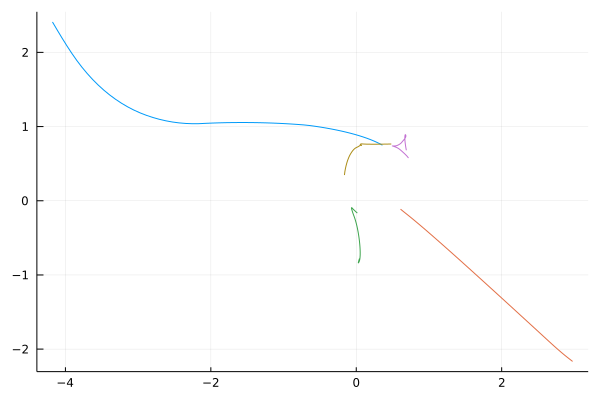

In [8]:
net_path = "../nnet/unicycle-FC3-100-rk4/epoch_1000.nnet"
draw_tracking_compare(net_path, 3, 60, 5)

In [8]:
net_path = "../nnet/unicycle-FC3-100-rk4/epoch_1000.nnet"
net = read_nnet(net_path);
obj_cost = [1,1,10,10];
Random.seed!(127);

tf = 3
T = 30
Xrefs, Urefs = generate_random_traj(net, 1, tf, T);
Xref=Xrefs[1]
tp = TP(net, obj_cost, tf, Xref);

In [10]:

Utracks = []

ctrl = ShootingController(100)
Xtrack, Utrack, time = tracking(tp, ctrl, verbose=false, only_one_step=false)
push!(Utracks, Utrack)

ctrl = ShootingController(1000)
Xtrack, Utrack, time = tracking(tp, ctrl, verbose=false, only_one_step=false)
push!(Utracks, Utrack)

2-element Array{Any,1}:
 [[1.5999438086216191, -0.334021170987465], [0.38852575072094275, 1.009832809597385], [0.8652583060555177, -0.09249280241837532], [1.044875258115212, -0.08520201207427913], [0.7483486942855446, 0.5556508617770421], [1.035482705511864, -0.8662391504731453], [1.1716653532201402, -1.0953474207791256], [0.5712719630948904, -0.7630119417867691], [0.8246537899979227, -0.8452484495417787], [0.1643520641988978, -0.8889135118579241]  …  [-0.4634384227696682, -0.17511947108326575], [-0.5162670900406621, -0.7725493194269233], [-0.819840242531825, -0.9607231583225988], [-0.5605957185088712, -0.8684738761775215], [-0.655462724224801, -0.6462004944306896], [-1.5793558138189496, -0.9673606053853563], [0.18722424206766775, -0.9019050241604352], [-1.7884520385569456, -0.9902812480052647], [-0.8048808703842596, -0.6526191282127218], [-1.6061414640313991, -0.8902370556259953]]
 [[0.9862752356377396, 0.030298910385553768], [0.9059350679851423, 0.2783563807870877], [1.06065992248550

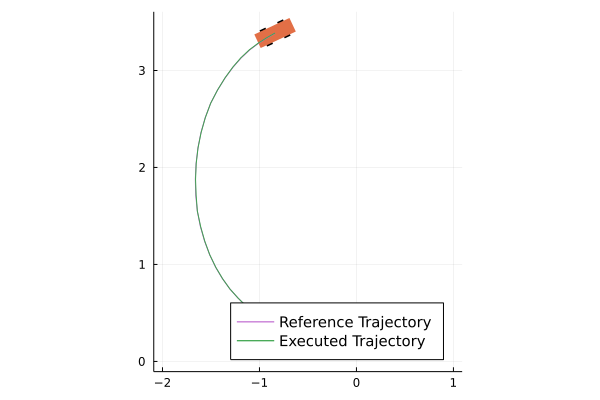

true

In [11]:
visualize(Xtrack, Xref=Xref, xlims=[-2,1], ylims=[0,3.5])

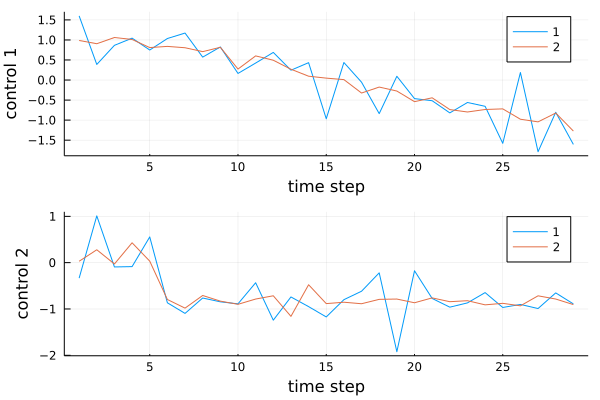

In [21]:
p1 = plot()
p2 = plot()
for i = 1:length(Utracks)
    uv = [u[1] for u in Utracks[i]]
    ua = [u[2] for u in Utracks[i]]
    plot!(p1, uv, label=string(i))
    plot!(p2, ua, label=string(i))
end
xlabel!(p1, "time step")
xlabel!(p2, "time step")
ylabel!(p1, "control 1")
ylabel!(p2, "control 2")
l = @layout [a; b]
plot(p1, p2, layout = l)